# Start of the file
-   robust MAD normalization and clipping, k=15
-   model training, training / validation as 0.9/0.1 splitting 


In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
# from astropy.timeseries import LombScargleMultiband
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import hdbscan
import os
import torch
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
# import pacmap
import pickle
from sklearn.model_selection import train_test_split

print(torch.__version__)
print(torch.cuda.is_available())  # Check if CUDA is available (if using GPU)
print(torch.cuda.device_count())  # Check how many GPUs are available
print(torch.cuda.get_device_name(0))  # Get the name of the first GPU
print(torch.cuda.current_device())  # Get the current GPU device

# Check if cuDNN is enabled
print(torch.backends.cudnn.enabled)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)


2.6.0+cu118
True
1
NVIDIA GeForce RTX 4060 Ti
0
True
cuda:0


# Preprocess

In [ ]:
with open("files_dataframe.pickle", "rb") as f:
  files_dataframe = pickle.load(f)


# EDA

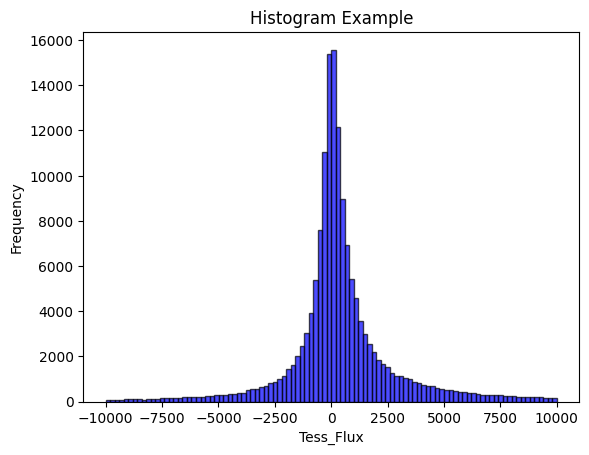

max flux 12240514.06883628
min flux -312846315.45374
Percentage (excluding NaN): 99.88%


In [ ]:
# tess_flux histogram
import matplotlib.pyplot as plt
import numpy as np

# Create a histogram
plt.hist(files_dataframe[abs(files_dataframe['tess_flux']) < 1e4]['tess_flux'].tolist(), bins=100, color='blue', alpha=0.7, edgecolor='black')

# Add labels and title
# plt.xscale('log')
plt.xlabel('Tess_Flux')
plt.ylabel('Frequency')
plt.title('Histogram Example')

# Show the plot
plt.show()

data_all = files_dataframe['tess_flux'].tolist()
print("max flux", max(data_all))
# 12,240,514.06883628 = 1.2e7
print("min flux", min(data_all))
# -312,846,315.45374 = -3.1e8

# Count non-NaN values first
total_non_nan = files_dataframe['tess_flux'].notna().sum()
below_threshold = ((files_dataframe['tess_flux'].abs() < 1.1e6) & 
                   files_dataframe['tess_flux'].notna()).sum()
percentage = (below_threshold / total_non_nan) * 100
print(f"Percentage (excluding NaN): {percentage:.2f}%")

# max flux 12240514.06883628
# min flux -312846315.45374
# Percentage (excluding NaN): 92.27% (1e4 threshold)
# Percentage (excluding NaN): 99.88% (1.1e6 threshold)

In [ ]:
# extreme objects
files_dataframe[files_dataframe['tess_flux'].abs() > 12240514.]

# 2019dhm

,relative_time,tess_flux,tess_uncert,object_name,apparent_mag
24,1.5,-3.128463e+08,1086.019379,2019dhm,NaN
48,10.5,-1.247704e+07,3278.013864,2020tgq,NaN
36,3.0,1.224051e+07,2792.384343,2019kli,NaN


In [18]:
from scipy.stats import median_abs_deviation
from tqdm import tqdm

def preprocess_lcs_per_object(df, set='train'):
    """
    Preprocess TESS light curves with per-object normalization and uncertainty weighting.
    
    Key changes from original:
    1. Per-object normalization (median + robust MAD scaling)
    2. Inverse-variance weighting using uncertainties
    3. Outlier handling using robust statistics per object
    4. Preserves astrophysical information while normalizing scale
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe with columns: 'object_name', 'tess_flux', 'tess_uncert', 'relative_time'
    set : str
        Dataset identifier ('train', 'val', 'test')
    
    Returns
    -------
    oids_used : list
        Object IDs that passed preprocessing
    target_class : list
        Class labels (if available) or object names
    data : list of np.array
        Normalized time-flux pairs for each object
    uncertainties : list of np.array
        Scaled uncertainties (time-uncertainty pairs)
    weights : list of np.array
        Inverse-variance weights for each data point
    normalization_params : dict
        Parameters used for normalization (for inverse transformation)
    """
    
    # Clean data
    df = df.copy()
    df = df[~df['tess_flux'].isna() & ~df['tess_uncert'].isna()]
    
    oids = np.unique(df['object_name'])
    
    data = []
    uncertainties = []
    weights = []
    target_class = []
    oids_used = []
    normalization_params = {}  # Store for potential inverse transformation
    
    print(f"=== Preprocessing with per-object normalization ===")
    print(f"Number of objects: {len(oids)}")
    
    for oid in tqdm(oids, desc=f"Processing {set} objects"):
        lc = df[df['object_name'] == oid].copy()
        
        if len(lc) < 20:  # Minimum points requirement
            continue
        
        # 1. Handle extreme outliers per object using robust statistics
        # Use median and MAD instead of mean/std for outlier detection
        median_flux = np.median(lc['tess_flux'])
        mad_flux = median_abs_deviation(lc['tess_flux'], scale='normal')
        
        # Define outlier bounds (e.g., median ± 5*MAD)
        lower_bound = median_flux - 15 * mad_flux
        upper_bound = median_flux + 15 * mad_flux
        
        # Clip extreme outliers (not all high/low values, just extremes)
        n_extreme = ((lc['tess_flux'] < lower_bound) | (lc['tess_flux'] > upper_bound)).sum()
        if n_extreme > 0:
            # Cap extreme values at bounds (preserves more data than removal)
            lc.loc[lc['tess_flux'] < lower_bound, 'tess_flux'] = lower_bound
            lc.loc[lc['tess_flux'] > upper_bound, 'tess_flux'] = upper_bound
        
        # 2. PER-OBJECT NORMALIZATION
        # Calculate robust normalization parameters
        robust_median = np.median(lc['tess_flux'])
        robust_mad = median_abs_deviation(lc['tess_flux'], scale='normal')
        
        # Handle edge case: very small or zero variability
        if robust_mad < 1e-10:
            # Use standard deviation as fallback
            robust_mad = np.std(lc['tess_flux'])
            if robust_mad < 1e-10:
                robust_mad = 1.0  # Avoid division by zero
        
        # Normalize flux: (flux - median) / robust_mad
        # This gives zero median, unit robust variance
        flux_normalized = (lc['tess_flux'] - robust_median) / robust_mad
        
        # Scale uncertainties by the same factor
        uncert_scaled = lc['tess_uncert'] / robust_mad
        
        # 3. INVERSE-VARIANCE WEIGHTING
        # Weight = 1/σ² (inverse variance)
        # Add small epsilon to avoid division by zero
        epsilon = 1e-10
        weights_raw = 1.0 / (uncert_scaled**2 + epsilon)
        
        # Normalize weights to have max weight = 1 (optional but helps training)
        if weights_raw.max() > 0:
            weights_normalized = weights_raw / weights_raw.max()
        else:
            weights_normalized = np.ones_like(weights_raw)
        
        # 4. Time normalization (relative to start)
        time_normalized = lc['relative_time'] - np.min(lc['relative_time'])
        
        # 5. Store normalization parameters for this object
        normalization_params[oid] = {
            'median': robust_median,
            'mad': robust_mad,
            'n_points': len(lc),
            'n_extreme_clipped': n_extreme
            
        }
        
        # 6. Subsampling to fixed length (if needed for your model)
        if len(lc) > 100:
            # IMPORTANT: Sample while preserving time order and uncertainties
            indices = np.linspace(0, len(lc)-1, 100, dtype=int)
            flux_normalized = flux_normalized.iloc[indices]
            time_normalized = time_normalized.iloc[indices]
            uncert_scaled = uncert_scaled.iloc[indices]
            weights_normalized = weights_normalized[indices]
        
        elif len(lc) < 30:  # Skip objects with too few points after potential subsampling
            continue
        
        # 7. Prepare output arrays
        # Data: [time, normalized_flux]
        data.append(np.column_stack([time_normalized.values, flux_normalized.values]))
        
        # Uncertainties: [time, scaled_uncertainty]
        uncertainties.append(np.column_stack([time_normalized.values, uncert_scaled.values]))
        
        # Weights: inverse-variance weights
        weights.append(weights_normalized)
        
        # Store object info
        oids_used.append(oid)
        target_class.append(oid)  # Or use actual class if available
        
        # Optional: Store class label if available in dataframe
        if 'class' in lc.columns:
            target_class[-1] = lc['class'].iloc[0]
    
    print(f"=== Preprocessing complete ===")
    print(f"Processed objects: {len(oids_used)} / {len(oids)}")
    print(f"Average points per object: {np.mean([len(d) for d in data]):.1f}")
    
    # Print summary statistics
    if normalization_params:
        medians = [p['median'] for p in normalization_params.values()]
        mads = [p['mad'] for p in normalization_params.values()]
        print(f"Median of medians: {np.median(medians):.2f}")
        print(f"Median MAD: {np.median(mads):.2f}")
        print(f"Total extreme values clipped: {sum([p['n_extreme_clipped'] for p in normalization_params.values()])}")
    
    return oids_used, target_class, data, uncertainties, weights, normalization_params


# Use the enhanced preprocessing
all_ids, all_labels, all_data, all_uncertainties, all_weights, normalization_params = preprocess_lcs_per_object(files_dataframe)

=== Preprocessing with per-object normalization ===
Number of objects: 3659


Processing train objects: 100%|██████████| 3659/3659 [00:19<00:00, 183.27it/s]

=== Preprocessing complete ===
Processed objects: 3593 / 3659
Average points per object: 46.2
Median of medians: 193.28
Median MAD: 983.81
Total extreme values clipped: 580


In [92]:
count = 1
for key in normalization_params.keys():
    if normalization_params[key]['n_extreme_clipped'] > 0:  
        count += 1

print(f"Number of objects with extreme clipping: {count}")

Number of objects with extreme clipping: 152


lower_bound: -23879.03613635634, upper_bound: 22480.157527326588
k=3
Median of medians: 194.07
Median MAD: 987.79
Total extreme values clipped: 665
lower_bound: -39332.100690917316, upper_bound: 37933.222081887565
k=5
Median of medians: 193.40
Median MAD: 987.79
Total extreme values clipped: 652
lower_bound: -77964.76207731976, upper_bound: 76565.88346829
k=10
Median of medians: 193.23
Median MAD: 987.79
Total extreme values clipped: 636
lower_bound: -116597.42346372218, upper_bound: 115198.54485469243
k=15
Median of medians: 193.17
Median MAD: 987.79
Total extreme values clipped: 623
lower_bound: -193862.74623652708, upper_bound: 192463.86762749733
k=25
Median of medians: 193.12
Median MAD: 987.79
Total extreme values clipped: 615


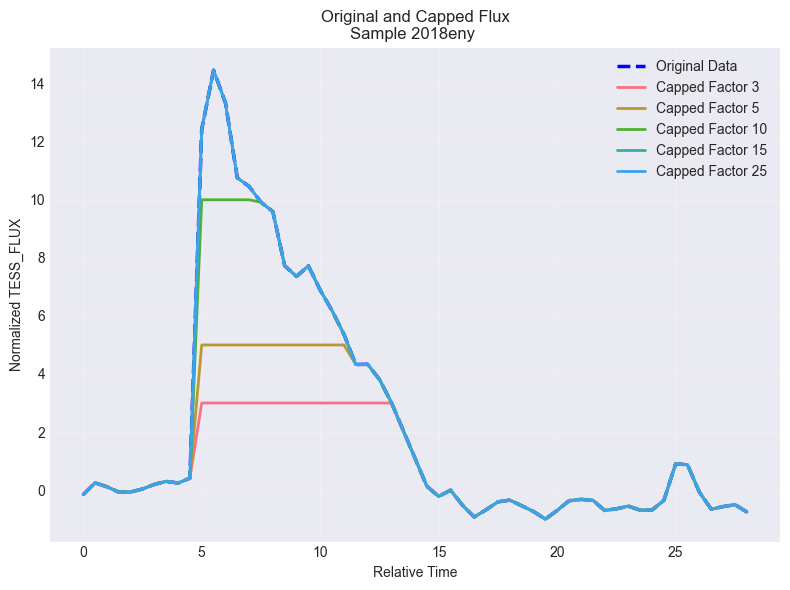

In [ ]:
# Example visualization of the effect of different capping factors
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import median_abs_deviation
from tqdm import tqdm

label_name = '2018eny'
# label_name = '2019kli'
# label_name = '2021soz'
# label_name = '20200fyf'
# label_name = '2019bgp'

df = files_dataframe.copy()
df = df[df['object_name']==label_name]
df = df[~df['tess_flux'].isna() & ~df['tess_uncert'].isna()]

data = {}
orig_data = []

def preprocess_lcs_per_object(df, ks, set='train'):
    """
    Preprocess TESS light curves with per-object normalization and uncertainty weighting.
    
    Key changes from original:
    1. Per-object normalization (median + robust MAD scaling)
    2. Inverse-variance weighting using uncertainties
    3. Outlier handling using robust statistics per object
    4. Preserves astrophysical information while normalizing scale
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe with columns: 'object_name', 'tess_flux', 'tess_uncert', 'relative_time'
    set : str
        Dataset identifier ('train', 'val', 'test')
    
    Returns
    -------
    oids_used : list
        Object IDs that passed preprocessing
    target_class : list
        Class labels (if available) or object names
    data : list of np.array
        Normalized time-flux pairs for each object
    uncertainties : list of np.array
        Scaled uncertainties (time-uncertainty pairs)
    weights : list of np.array
        Inverse-variance weights for each data point
    normalization_params : dict
        Parameters used for normalization (for inverse transformation)
    """
        
    for k in ks:
        lc = df.copy()

        if len(lc) < 20:  # Minimum points requirement
            continue
        
        # 1. Handle extreme outliers per object using robust statistics
        # Use median and MAD instead of mean/std for outlier detection
        median_flux = np.median(lc['tess_flux'])
        mad_flux = median_abs_deviation(lc['tess_flux'], scale='normal')
        
        # Define outlier bounds (e.g., median ± 5*MAD)
        lower_bound = median_flux - k * mad_flux
        upper_bound = median_flux + k * mad_flux
        
        print(f"lower_bound: {lower_bound}, upper_bound: {upper_bound}")

        # Clip extreme outliers (not all high/low values, just extremes)
        n_extreme = ((lc['tess_flux'] < lower_bound) | (lc['tess_flux'] > upper_bound)).sum()
        if n_extreme > 0:
            # Cap extreme values at bounds (preserves more data than removal)
            lc.loc[lc['tess_flux'] < lower_bound, 'tess_flux'] = lower_bound
            lc.loc[lc['tess_flux'] > upper_bound, 'tess_flux'] = upper_bound
        
        # 2. PER-OBJECT NORMALIZATION
        # Calculate robust normalization parameters
        robust_median = np.median(lc['tess_flux'])
        robust_mad = median_abs_deviation(lc['tess_flux'], scale='normal')
        
        # Handle edge case: very small or zero variability
        if robust_mad < 1e-10:
            # Use standard deviation as fallback
            robust_mad = np.std(lc['tess_flux'])
            if robust_mad < 1e-10:
                robust_mad = 1.0  # Avoid division by zero
        
        # Normalize flux: (flux - median) / robust_mad
        # This gives zero median, unit robust variance
        flux_normalized = (lc['tess_flux'] - robust_median) / robust_mad
        flux_orig = (df['tess_flux'] - robust_median) / robust_mad
        
        # Scale uncertainties by the same factor
        uncert_scaled = lc['tess_uncert'] / robust_mad
        
        # 3. INVERSE-VARIANCE WEIGHTING
        # Weight = 1/σ² (inverse variance)
        # Add small epsilon to avoid division by zero
        epsilon = 1e-10
        weights_raw = 1.0 / (uncert_scaled**2 + epsilon)
        
        # Normalize weights to have max weight = 1 (optional but helps training)
        if weights_raw.max() > 0:
            weights_normalized = weights_raw / weights_raw.max()
        else:
            weights_normalized = np.ones_like(weights_raw)
        
        # 4. Time normalization (relative to start)
        time_normalized = lc['relative_time'] - np.min(lc['relative_time'])
        
        # 5. Store normalization parameters for this object
        normalization_params[k] = {
            'median': robust_median,
            'mad': robust_mad,
            'n_points': len(lc),
            'n_extreme_clipped': n_extreme
            
        }

        # 7. Prepare output arrays
        # Data: [time, normalized_flux]
        data[k] = np.column_stack([time_normalized.values, flux_normalized.values])
        orig_data = np.column_stack([time_normalized.values, flux_orig.values])

    # Print summary statistics
    # if normalization_params:
        print(f"k={k}")
        medians = [p['median'] for p in normalization_params.values()]
        mads = [p['mad'] for p in normalization_params.values()]
        print(f"Median of medians: {np.median(medians):.2f}")
        print(f"Median MAD: {np.median(mads):.2f}")
        print(f"Total extreme values clipped: {sum([p['n_extreme_clipped'] for p in normalization_params.values()])}")
    
    return data, orig_data


# for k in [3, 5, 10, 15, 25]:
output, orig_data = preprocess_lcs_per_object(df, ks= [3, 5, 10, 15, 25])

plt.figure(figsize=(8, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b--', linewidth=2.5, label='Original Data')

for k in [3, 5, 10, 15, 25]:
    recon_data = output[k]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='-', label=f'Capped Factor {k}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Capped Flux\nSample {label_name} ')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()


In [100]:
from scipy.stats import median_abs_deviation
from tqdm import tqdm

def preprocess_lcs_per_object(df, k, set='train'):
    """
    Preprocess TESS light curves with per-object normalization and uncertainty weighting.
    
    Key changes from original:
    1. Per-object normalization (median + robust MAD scaling)
    2. Inverse-variance weighting using uncertainties
    3. Outlier handling using robust statistics per object
    4. Preserves astrophysical information while normalizing scale
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe with columns: 'object_name', 'tess_flux', 'tess_uncert', 'relative_time'
    set : str
        Dataset identifier ('train', 'val', 'test')
    
    Returns
    -------
    oids_used : list
        Object IDs that passed preprocessing
    target_class : list
        Class labels (if available) or object names
    data : list of np.array
        Normalized time-flux pairs for each object
    uncertainties : list of np.array
        Scaled uncertainties (time-uncertainty pairs)
    weights : list of np.array
        Inverse-variance weights for each data point
    normalization_params : dict
        Parameters used for normalization (for inverse transformation)
    """
    
    # Clean data
    df = df.copy()
    df = df[~df['tess_flux'].isna() & ~df['tess_uncert'].isna()]
    
    oids = np.unique(df['object_name'])
    
    data = []
    uncertainties = []
    weights = []
    target_class = []
    oids_used = []
    normalization_params = {}  # Store for potential inverse transformation
    
    print(f"=== Preprocessing with per-object normalization ===")
    print(f"Number of objects: {len(oids)}")
    
    for oid in tqdm(oids, desc=f"Processing {set} objects"):
        lc = df[df['object_name'] == oid].copy()
        
        if len(lc) < 20:  # Minimum points requirement
            continue
        
        # 1. Handle extreme outliers per object using robust statistics
        # Use median and MAD instead of mean/std for outlier detection
        median_flux = np.median(lc['tess_flux'])
        mad_flux = median_abs_deviation(lc['tess_flux'], scale='normal')
        
        # Define outlier bounds (e.g., median ± 5*MAD)
        lower_bound = median_flux - k * mad_flux
        upper_bound = median_flux + k * mad_flux
        
        # Clip extreme outliers (not all high/low values, just extremes)
        n_extreme = ((lc['tess_flux'] < lower_bound) | (lc['tess_flux'] > upper_bound)).sum()
        if n_extreme > 0:
            # Cap extreme values at bounds (preserves more data than removal)
            lc.loc[lc['tess_flux'] < lower_bound, 'tess_flux'] = lower_bound
            lc.loc[lc['tess_flux'] > upper_bound, 'tess_flux'] = upper_bound
        
        # 2. PER-OBJECT NORMALIZATION
        # Calculate robust normalization parameters
        robust_median = np.median(lc['tess_flux'])
        robust_mad = median_abs_deviation(lc['tess_flux'], scale='normal')
        
        # Handle edge case: very small or zero variability
        if robust_mad < 1e-10:
            # Use standard deviation as fallback
            robust_mad = np.std(lc['tess_flux'])
            if robust_mad < 1e-10:
                robust_mad = 1.0  # Avoid division by zero
        
        # Normalize flux: (flux - median) / robust_mad
        # This gives zero median, unit robust variance
        flux_normalized = (lc['tess_flux'] - robust_median) / robust_mad
        
        # Scale uncertainties by the same factor
        uncert_scaled = lc['tess_uncert'] / robust_mad
        
        # 3. INVERSE-VARIANCE WEIGHTING
        # Weight = 1/σ² (inverse variance)
        # Add small epsilon to avoid division by zero
        epsilon = 1e-10
        weights_raw = 1.0 / (uncert_scaled**2 + epsilon)
        
        # Normalize weights to have max weight = 1 (optional but helps training)
        if weights_raw.max() > 0:
            weights_normalized = weights_raw / weights_raw.max()
        else:
            weights_normalized = np.ones_like(weights_raw)
        
        # 4. Time normalization (relative to start)
        time_normalized = lc['relative_time'] - np.min(lc['relative_time'])
        
        # 5. Store normalization parameters for this object
        normalization_params[oid] = {
            'median': robust_median,
            'mad': robust_mad,
            'n_points': len(lc),
            'n_extreme_clipped': n_extreme
            
        }
        
        # 6. Subsampling to fixed length (if needed for your model)
        if len(lc) > 100:
            # IMPORTANT: Sample while preserving time order and uncertainties
            indices = np.linspace(0, len(lc)-1, 100, dtype=int)
            flux_normalized = flux_normalized.iloc[indices]
            time_normalized = time_normalized.iloc[indices]
            uncert_scaled = uncert_scaled.iloc[indices]
            weights_normalized = weights_normalized[indices]
        
        elif len(lc) < 30:  # Skip objects with too few points after potential subsampling
            continue
        
        # 7. Prepare output arrays
        # Data: [time, normalized_flux]
        data.append(np.column_stack([time_normalized.values, flux_normalized.values]))
        
        # Uncertainties: [time, scaled_uncertainty]
        uncertainties.append(np.column_stack([time_normalized.values, uncert_scaled.values]))
        
        # Weights: inverse-variance weights
        weights.append(weights_normalized)
        
        # Store object info
        oids_used.append(oid)
        target_class.append(oid)  # Or use actual class if available
        
        # Optional: Store class label if available in dataframe
        if 'class' in lc.columns:
            target_class[-1] = lc['class'].iloc[0]
    
    print(f"=== Preprocessing complete ===")
    print(f"Processed objects: {len(oids_used)} / {len(oids)}")
    print(f"Average points per object: {np.mean([len(d) for d in data]):.1f}")
    
    # Print summary statistics
    if normalization_params:
        medians = [p['median'] for p in normalization_params.values()]
        mads = [p['mad'] for p in normalization_params.values()]
        print(f"Median of medians: {np.median(medians):.2f}")
        print(f"Median MAD: {np.median(mads):.2f}")
        print(f"Total extreme values clipped: {sum([p['n_extreme_clipped'] for p in normalization_params.values()])}")
    
    count = 1

    for key in normalization_params.keys():
        if normalization_params[key]['n_extreme_clipped'] > 0:  
            count += 1

    print(f"Number of objects with extreme clipping: {count}")

    return k, sum([p['n_extreme_clipped'] for p in normalization_params.values()]) / len(oids_used) / np.mean([len(d) for d in data]), count


capped_counts = []

for k in [3, 5, 10, 15, 25]:
    k, percentage, count_lcs = preprocess_lcs_per_object(files_dataframe, k)
    capped_counts.append((k, percentage, count_lcs))
print(capped_counts)


=== Preprocessing with per-object normalization ===
Number of objects: 3659


Processing train objects: 100%|██████████| 3659/3659 [00:20<00:00, 179.98it/s]


=== Preprocessing complete ===
Processed objects: 3593 / 3659
Average points per object: 46.2
Median of medians: 193.28
Median MAD: 983.81
Total extreme values clipped: 7157
Number of objects with extreme clipping: 1704
=== Preprocessing with per-object normalization ===
Number of objects: 3659


Processing train objects: 100%|██████████| 3659/3659 [00:20<00:00, 179.53it/s]


=== Preprocessing complete ===
Processed objects: 3593 / 3659
Average points per object: 46.2
Median of medians: 193.28
Median MAD: 983.81
Total extreme values clipped: 2965
Number of objects with extreme clipping: 762
=== Preprocessing with per-object normalization ===
Number of objects: 3659


Processing train objects: 100%|██████████| 3659/3659 [00:20<00:00, 182.59it/s]


=== Preprocessing complete ===
Processed objects: 3593 / 3659
Average points per object: 46.2
Median of medians: 193.28
Median MAD: 983.81
Total extreme values clipped: 1072
Number of objects with extreme clipping: 256
=== Preprocessing with per-object normalization ===
Number of objects: 3659


Processing train objects: 100%|██████████| 3659/3659 [00:20<00:00, 180.51it/s]


=== Preprocessing complete ===
Processed objects: 3593 / 3659
Average points per object: 46.2
Median of medians: 193.28
Median MAD: 983.81
Total extreme values clipped: 580
Number of objects with extreme clipping: 147
=== Preprocessing with per-object normalization ===
Number of objects: 3659


Processing train objects: 100%|██████████| 3659/3659 [00:20<00:00, 177.49it/s]

=== Preprocessing complete ===
Processed objects: 3593 / 3659
Average points per object: 46.2
Median of medians: 193.28
Median MAD: 983.81
Total extreme values clipped: 287
Number of objects with extreme clipping: 74
[(3, np.float64(0.043130306920012774), 1704), (5, np.float64(0.01786801173925358), 762), (10, np.float64(0.006460205256148344), 256), (15, np.float64(0.0034952603064981706), 147), (25, np.float64(0.0017295512206292672), 74)]


In [101]:
for item in capped_counts:
    print(f"k={item[0]}, avg extreme clipped per point: {item[1]:.6f}")

k = [item[0] for item in capped_counts]
data = [item[1] for item in capped_counts]
print("k values:", k)
print("data values:", data)

k=3, avg extreme clipped per point: 0.043130
k=5, avg extreme clipped per point: 0.017868
k=10, avg extreme clipped per point: 0.006460
k=15, avg extreme clipped per point: 0.003495
k=25, avg extreme clipped per point: 0.001730
k values: [3, 5, 10, 15, 25]
data values: [np.float64(0.043130306920012774), np.float64(0.01786801173925358), np.float64(0.006460205256148344), np.float64(0.0034952603064981706), np.float64(0.0017295512206292672)]


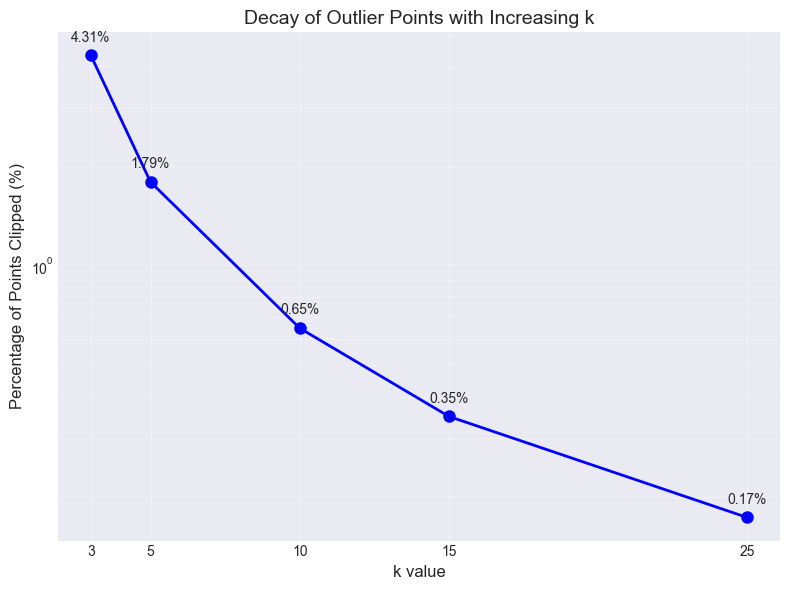

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
k_values = [item[0] for item in capped_counts]
percentages = [item[1] * 100 for item in capped_counts] 
# Create the plot
plt.figure(figsize=(8, 6))

# Logarithmic plot to show decay
plt.plot(k_values, percentages, 'bo-', linewidth=2, markersize=8)
plt.xlabel('k value', fontsize=12)
plt.ylabel('Percentage of Points Clipped (%)', fontsize=12)
plt.title('Decay of Outlier Points with Increasing k', fontsize=14)
plt.yscale('log')
plt.grid(True, alpha=0.3, which='both')
# plt.grid(True,  which='both')

# Add value annotations
for k, pct in zip(k_values, percentages):
    plt.annotate(f'{pct:.2f}%', (k, pct), textcoords="offset points", 
                 xytext=(0,10), ha='center', fontsize=10)

plt.xticks(k_values)
plt.tight_layout()
plt.show()

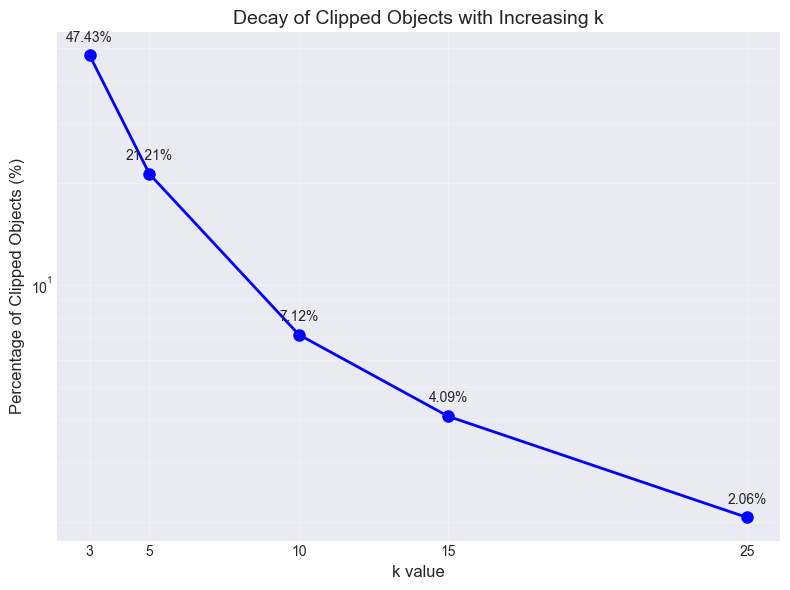

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
k_values = [item[0] for item in capped_counts]
clipped_counts = [item[2]/3593*100. for item in capped_counts] 

# Create the plot
plt.figure(figsize=(8, 6))

# Logarithmic plot to show decay
plt.plot(k_values, clipped_counts, 'bo-', linewidth=2, markersize=8)
plt.xlabel('k value', fontsize=12)
plt.ylabel('Percentage of Clipped Objects (%)', fontsize=12)
plt.title('Decay of Clipped Objects with Increasing k', fontsize=14)
plt.yscale('log')
plt.grid(True, alpha=0.3, which='both')
# plt.grid(True,  which='both')

# Add value annotations
for k, ct in zip(k_values, clipped_counts):
    plt.annotate(f'{ct:.2f}%', (k, ct), textcoords="offset points", 
                 xytext=(0,10), ha='center', fontsize=10)

plt.xticks(k_values)
plt.tight_layout()
plt.show()

In [19]:
class UncertaintyAwareLCDataset(Dataset):
    def __init__(self, data, uncertainties, weights, targets, ids, transform=None):
        self.data = data
        self.uncertainties = uncertainties
        self.weights = weights
        self.targets = targets
        self.ids = ids
        self.lengths = [len(seq) for seq in data]
        self.transform = transform

    def __getitem__(self, index):
        data = self.data[index]
        uncertainty = self.uncertainties[index]
        weights = self.weights[index]
        targets = self.targets[index]
        ids = self.ids[index]
        lengths = self.lengths[index]

        if self.transform:
            data = self.transform(data)
            uncertainty = self.transform(uncertainty)

        return data, uncertainty, weights, targets, ids, lengths

    def __len__(self):
        return len(self.data)

def uncertainty_collate_fn(batch):
    """Enhanced collate function that handles uncertainties and weights"""
    
    data, uncertainties, weights, targets, ids, lengths = zip(*batch)

    # Convert sequences to tensors and pad them
    sequences = [torch.tensor(d, dtype=torch.float32) for d in data]
    padded_sequences = pad_sequence(sequences, batch_first=True)
    
    # Pad uncertainties
    uncertainty_sequences = [torch.tensor(u, dtype=torch.float32) for u in uncertainties]
    padded_uncertainties = pad_sequence(uncertainty_sequences, batch_first=True)
    
    # Pad weights
    weight_sequences = [torch.tensor(w, dtype=torch.float32) for w in weights]
    padded_weights = pad_sequence(weight_sequences, batch_first=True)

    # Convert other data to tensors
    targets = torch.tensor(targets)
    ids = torch.tensor(ids)
    lengths = torch.tensor(lengths)

    return padded_sequences, padded_uncertainties, padded_weights, targets, ids, lengths

# Create enhanced datasets and data loaders
all_ds = UncertaintyAwareLCDataset(
    all_data, all_uncertainties, all_weights,
    [all_labels.index(id) for id in all_labels], 
    [all_ids.index(id) for id in all_ids]
)

all_loader = DataLoader(
    all_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    collate_fn=uncertainty_collate_fn,
    pin_memory=torch.cuda.is_available()
)

all_loader_no_shuffle = DataLoader(
    all_ds,
    batch_size=128,
    num_workers=0,
    shuffle=False,
    collate_fn=uncertainty_collate_fn,
    pin_memory=torch.cuda.is_available()
)

In [20]:
train_ids, val_ids, train_labels, val_labels, train_data, val_data, \
train_uncertainties, val_uncertainties, train_weights, val_weights = train_test_split(all_ids, all_labels, all_data, 
                                                    all_uncertainties, all_weights, test_size=0.1, random_state=42)

train_final_ids = [train_ids.index(id) for id in train_ids]
train_final_labels = [train_labels.index(id) for id in train_labels]

train_ds = UncertaintyAwareLCDataset(train_data, train_uncertainties, train_weights,
                                     [train_labels.index(id) for id in train_labels], [train_ids.index(id) for id in train_ids])
train_loader = DataLoader(
    train_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    collate_fn=uncertainty_collate_fn,
    pin_memory=torch.cuda.is_available()
)

val_ds = UncertaintyAwareLCDataset(val_data, val_uncertainties, val_weights,
                                   [val_labels.index(id) for id in val_labels], [val_ids.index(id) for id in val_ids] )
val_loader = DataLoader(
    val_ds,
    batch_size=128,
    num_workers=0,
    shuffle=True,
    collate_fn=uncertainty_collate_fn,
    pin_memory=torch.cuda.is_available()
)

# training

In [21]:
from src.util import Encoder, Decoder

class UncertaintyAwareRNN_VAE(torch.nn.Module):
    """RNN-VAE that incorporates measurement uncertainties"""
    
    def __init__(self, input_size=2, hidden_size=64, latent_size=16, dropout=0.2):
        super(UncertaintyAwareRNN_VAE, self).__init__()
        self.device = device
        
        # dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = 4
        self.dropout = dropout
        
        self.enc = Encoder(input_size=input_size, hidden_size=hidden_size, 
                          num_layers=self.num_layers, dropout=self.dropout)
        
        self.dec = Decoder(
            input_size=latent_size,
            output_size=input_size,
            hidden_size=hidden_size,
            dropout=self.dropout,
            num_layers=self.num_layers,
        )
        
        self.fc21 = torch.nn.Linear(self.hidden_size, self.latent_size)
        self.fc22 = torch.nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = torch.nn.Linear(self.latent_size, self.hidden_size)
    
    def reparameterize(self, mu, logvar):
        if self.training:
            return mu + torch.randn(mu.shape).to(device)*torch.exp(0.5*logvar)
        else:
            return mu
    
    def forward(self, x, lengths, weights=None):
        batch_size, seq_len, feature_dim = x.shape
        
        # encode input space
        enc_output, enc_hidden = self.enc(x, lengths)
        
        # Correctly accessing the hidden state of the last layer
        enc_h = enc_hidden[-1].to(device)
        
        # extract latent variable z
        mu = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparameterize(mu, logvar)
        
        # initialize hidden state
        h_ = self.fc3(z)
        h_ = h_.unsqueeze(0)
        h_ = h_.repeat(self.dec.num_layers, 1, 1)
        
        # decode latent space
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len, self.latent_size).to(device)
        
        # initialize hidden state
        hidden = h_.contiguous()
        x_hat, hidden = self.dec(z, hidden)
        
        return x_hat, mu, logvar

def uncertainty_weighted_ELBO(x_hat, x, mu, logvar, weights=None):
    """ELBO loss with uncertainty weighting"""
    
    # Reconstruction loss with uncertainty weights
    if weights is not None:
        # Expand weights to match x shape if needed
        if weights.dim() == 2:  # [batch_size, seq_len]
            weights = weights.unsqueeze(-1)  # [batch_size, seq_len, 1]
        
        # Weighted MSE
        weighted_MSE = torch.sum(weights * (x_hat - x)**2)
    else:
        weighted_MSE = torch.nn.MSELoss(reduction='sum')(x_hat, x)
    
    # KL divergence (unchanged)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return weighted_MSE + KLD

In [11]:
from pathlib import Path
from src.util import save_checkpoint, plot_model_loss


hidden_size=128
latent_size=16
nepochs = 1400
num_layers = 4

# save checkpoint every 20 epochs 
checkpoint_increment = 20

# Create a single folder
checkpoint_path = Path(f"checkpoint\RNN_VAE_lat{latent_size}_hid{hidden_size}_gru{num_layers}_norm_uncert_15m")
checkpoint_path.mkdir(parents=True, exist_ok=True)
print(f"checkpoint_path: {checkpoint_path}")

"""Training function that incorporates uncertainties"""

model = UncertaintyAwareRNN_VAE(hidden_size=hidden_size, latent_size=latent_size)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-4)

<>:14: SyntaxWarning: invalid escape sequence '\R'
<>:14: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_30872\2768461892.py:14: SyntaxWarning: invalid escape sequence '\R'
  checkpoint_path = Path(f"checkpoint\RNN_VAE_lat{latent_size}_hid{hidden_size}_gru{num_layers}_norm_uncert_15m")


checkpoint_path: checkpoint\RNN_VAE_lat16_hid128_gru4_norm_uncert_15m


<>:16: SyntaxWarning: invalid escape sequence '\R'
<>:71: SyntaxWarning: invalid escape sequence '\R'
<>:16: SyntaxWarning: invalid escape sequence '\R'
<>:71: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_27056\387342375.py:16: SyntaxWarning: invalid escape sequence '\R'
  checkpoint_path = Path(f"checkpoint\RNN_VAE_lat{latent_size}_hid{hidden_size}_gru{num_layers}_norm_uncert_15m")
C:\Users\xuesh\AppData\Local\Temp\ipykernel_27056\387342375.py:71: SyntaxWarning: invalid escape sequence '\R'
  checkpoint_path_file = f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epoch+1}.pth'


checkpoint_path: checkpoint\RNN_VAE_lat16_hid128_gru4_norm_uncert_15m
Beginning uncertainty-aware training...
Epoch 0 | Train: 8348.08 | Val: 8116.60
Epoch 1 | Train: 6999.28 | Val: 5761.32
Epoch 2 | Train: 5038.57 | Val: 4546.10
Epoch 3 | Train: 4212.06 | Val: 4036.55
Epoch 4 | Train: 3810.46 | Val: 3728.32
Epoch 5 | Train: 3534.86 | Val: 3485.26
Epoch 6 | Train: 3308.03 | Val: 3272.75
Epoch 7 | Train: 3106.93 | Val: 3078.72
Epoch 8 | Train: 2922.13 | Val: 2898.52
Epoch 9 | Train: 2750.80 | Val: 2730.20
Epoch 10 | Train: 2587.28 | Val: 2561.99
Epoch 11 | Train: 2390.92 | Val: 2290.51
Epoch 12 | Train: 1882.91 | Val: 1311.38
Epoch 13 | Train: 867.14 | Val: 605.25
Epoch 14 | Train: 425.38 | Val: 582.34
Epoch 15 | Train: 326.75 | Val: 410.73
Epoch 16 | Train: 302.37 | Val: 414.04
Epoch 17 | Train: 281.28 | Val: 399.51
Epoch 18 | Train: 266.12 | Val: 299.34
Epoch 19 | Train: 257.15 | Val: 306.40
Checkpoint saved at epoch 20 in the file: checkpoint\RNN_VAE_lat16_hid128_gru4_norm_uncert_15m

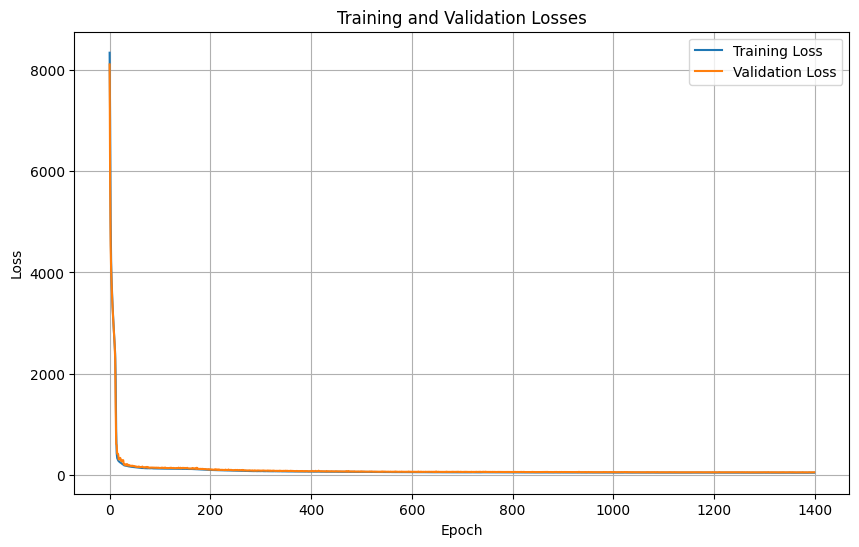

In [9]:
# def train_uncertainty_aware_vae(hidden_size=128, latent_size=16, nepochs=800):

from pathlib import Path
from src.util import save_checkpoint, plot_model_loss


hidden_size=128
latent_size=16
nepochs = 1400
num_layers = 4

# save checkpoint every 20 epochs 
checkpoint_increment = 20

# Create a single folder
checkpoint_path = Path(f"checkpoint\RNN_VAE_lat{latent_size}_hid{hidden_size}_gru{num_layers}_norm_uncert_15m")
checkpoint_path.mkdir(parents=True, exist_ok=True)
print(f"checkpoint_path: {checkpoint_path}")

"""Training function that incorporates uncertainties"""

model = UncertaintyAwareRNN_VAE(hidden_size=hidden_size, latent_size=latent_size)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-4)

training_losses = []
validation_losses = []

print("Beginning uncertainty-aware training...")
for epoch in range(nepochs):
    # Training phase
    model.train()
    train_loss = 0
    
    for x, uncertainties, weights, labels, ids, lengths in train_loader:
        x = x.to(device)
        weights = weights.to(device)
        
        x_hat, mu, logvar = model(x, lengths)
        loss = uncertainty_weighted_ELBO(x_hat, x, mu, logvar, weights)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    training_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for x, uncertainties, weights, labels, ids, lengths in val_loader:
            x = x.to(device)
            weights = weights.to(device)
            
            x_hat, mu, logvar = model(x, lengths)
            loss = uncertainty_weighted_ELBO(x_hat, x, mu, logvar, weights)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    validation_losses.append(avg_val_loss)

    print(f'Epoch {epoch} | Train: {avg_train_loss:.2f} | Val: {avg_val_loss:.2f}')

        # Save model checkpoint every checkpoint_increment epochs
    if (epoch + 1) % checkpoint_increment == 0:
        checkpoint_path_file = f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epoch+1}.pth'
        save_checkpoint(epoch+1, model, optimizer, avg_train_loss, avg_val_loss, training_losses, validation_losses, path=checkpoint_path_file)
        print(f'Model checkpoint saved at {checkpoint_path_file}')

plot_model_loss(training_losses, validation_losses)


# load model

can skip

In [22]:
from pathlib import Path
from src.util import save_checkpoint, plot_model_loss


hidden_size=128
latent_size=16
nepochs = 1400
num_layers = 4

# save checkpoint every 20 epochs 
checkpoint_increment = 20

# Create a single folder
checkpoint_path = Path(f"checkpoint\RNN_VAE_lat{latent_size}_hid{hidden_size}_gru{num_layers}_norm_uncert_15m")
checkpoint_path.mkdir(parents=True, exist_ok=True)
print(f"checkpoint_path: {checkpoint_path}")

"""Training function that incorporates uncertainties"""

model = UncertaintyAwareRNN_VAE(hidden_size=hidden_size, latent_size=latent_size)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-4)

training_losses = []
validation_losses = []


<>:14: SyntaxWarning: invalid escape sequence '\R'
<>:14: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_38196\3379420693.py:14: SyntaxWarning: invalid escape sequence '\R'
  checkpoint_path = Path(f"checkpoint\RNN_VAE_lat{latent_size}_hid{hidden_size}_gru{num_layers}_norm_uncert_15m")


checkpoint_path: checkpoint\RNN_VAE_lat16_hid128_gru4_norm_uncert_15m


<>:20: SyntaxWarning: invalid escape sequence '\R'
<>:20: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_38196\286555265.py:20: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 800
Resumed from epoch: 800
checkpoint_path: checkpoint\RNN_VAE_lat16_hid128_gru4_norm_uncert_15m


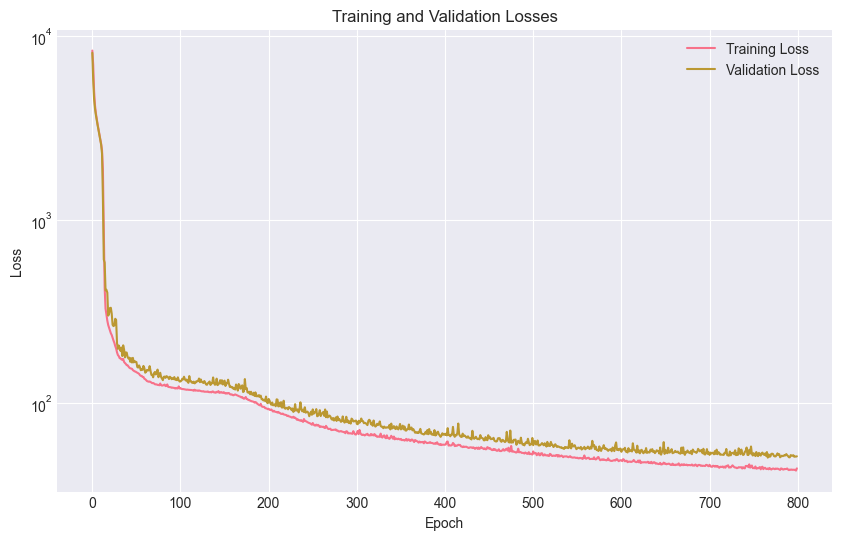

In [23]:
from src.util import resume_training
def plot_model_loss(training_losses, validation_losses):

    # Plot training and validation losses
    plt.figure(figsize=(10, 6))

    plt.plot(range(len(training_losses)), training_losses, label='Training Loss')
    plt.plot(range(len(validation_losses)), validation_losses, label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Training and Validation Losses')

    plt.legend()
    plt.grid(True)
    plt.show()

epochs = 800
start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
# start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch800.pth', model, optimizer)

print(f"Resumed from epoch: {start_epoch}")
print(f"checkpoint_path: {checkpoint_path}")
plot_model_loss(training_losses, validation_losses)

# re-training

<>:47: SyntaxWarning: invalid escape sequence '\R'
<>:47: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_2992\2248375125.py:47: SyntaxWarning: invalid escape sequence '\R'
  checkpoint_path_file = f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epoch+1}.pth'


start_epoch: 1400
Beginning training...
Epoch 1400 | Train: 34.87 | Val: 34.93
Epoch 1401 | Train: 34.91 | Val: 37.18
Epoch 1402 | Train: 35.27 | Val: 34.81
Epoch 1403 | Train: 34.77 | Val: 34.38
Epoch 1404 | Train: 34.52 | Val: 34.19
Epoch 1405 | Train: 34.59 | Val: 34.32
Epoch 1406 | Train: 34.49 | Val: 34.99
Epoch 1407 | Train: 34.55 | Val: 35.23
Epoch 1408 | Train: 34.24 | Val: 33.98
Epoch 1409 | Train: 34.39 | Val: 34.67
Epoch 1410 | Train: 34.39 | Val: 35.22
Epoch 1411 | Train: 34.39 | Val: 35.49
Epoch 1412 | Train: 34.33 | Val: 34.24
Epoch 1413 | Train: 35.00 | Val: 35.47
Epoch 1414 | Train: 35.58 | Val: 34.08
Epoch 1415 | Train: 34.40 | Val: 34.49
Epoch 1416 | Train: 34.57 | Val: 35.00
Epoch 1417 | Train: 34.34 | Val: 34.58
Epoch 1418 | Train: 34.31 | Val: 34.89
Epoch 1419 | Train: 34.57 | Val: 34.24
Checkpoint saved at epoch 1420 in the file: checkpoint\RNN_VAE_lat16_hid128_gru4_norm_uncert_v20251213\RNN_VAE_checkpoint_epoch1420.pth
Model checkpoint saved at checkpoint\RNN_VAE

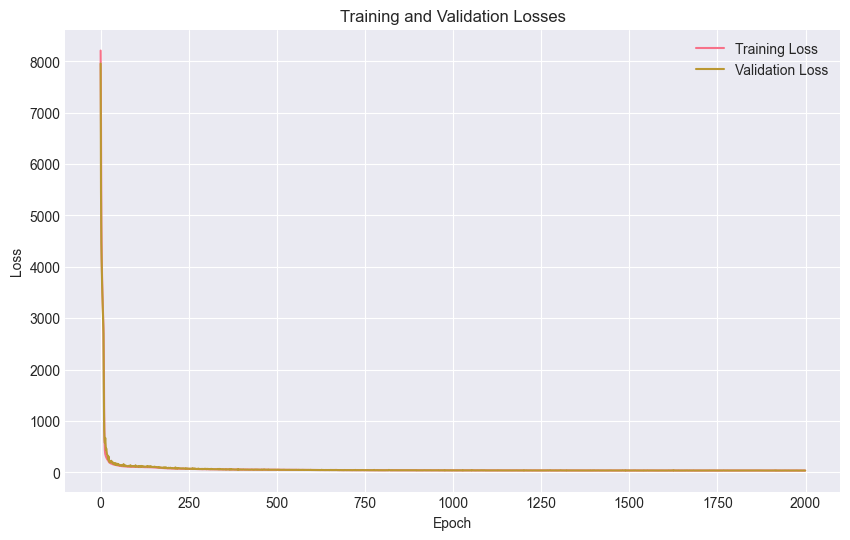

In [226]:
print(f"start_epoch: {start_epoch}")

# Continue training loop from start_epoch
print("Beginning training...")

for epoch in range(start_epoch, 2000):
    # set to training mode
    model.train()
    train_loss = 0
    
    for x, uncertainties, weights, labels, ids, lengths in train_loader:
        x = x.to(device)
        weights = weights.to(device)
        
        x_hat, mu, logvar = model(x, lengths)
        loss = uncertainty_weighted_ELBO(x_hat, x, mu, logvar, weights)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    training_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for x, uncertainties, weights, labels, ids, lengths in val_loader:
            x = x.to(device)
            weights = weights.to(device)
            
            x_hat, mu, logvar = model(x, lengths)
            loss = uncertainty_weighted_ELBO(x_hat, x, mu, logvar, weights)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    validation_losses.append(avg_val_loss)

    print(f'Epoch {epoch} | Train: {avg_train_loss:.2f} | Val: {avg_val_loss:.2f}')

        # Save model checkpoint every checkpoint_increment epochs
    if (epoch + 1) % checkpoint_increment == 0:
        checkpoint_path_file = f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epoch+1}.pth'
        save_checkpoint(epoch+1, model, optimizer, avg_train_loss, avg_val_loss, training_losses, validation_losses, path=checkpoint_path_file)
        print(f'Model checkpoint saved at {checkpoint_path_file}')

plot_model_loss(training_losses, validation_losses)


# Calculate latent space


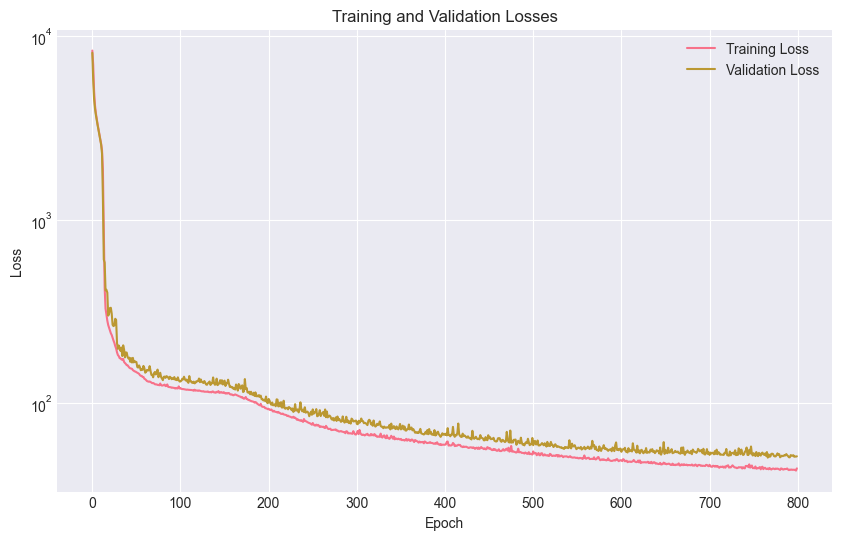

In [35]:
plot_model_loss(training_losses, validation_losses)


# Latent space analysis #1

k:\victor\python-project\torchenv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


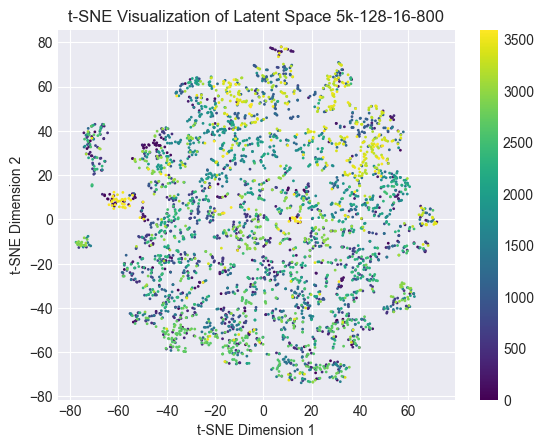

In [36]:
####### get latent features
# start_epoch = 600
import numpy as np
import torch.nn.utils.rnn as rnn

def get_clustered_data(model, data_loader):
  # Get latent representations for all data points
  with torch.no_grad():
    all_mus = []
    labels_latent = []

    for x, uncertainties, weights, labels, ids, lengths in data_loader:
        x = x.to(device)
        weights = weights.to(device)
        encoded, mu, logvar = model(x, lengths)
        all_mus.append(mu.to(device))
        labels_latent.append(labels.to(device))
        # print(labels)

    latent_data = torch.cat(all_mus, dim=0)
    latent_label = torch.cat(labels_latent, dim=0)

    return latent_data, latent_label


def tsne_transform(latent_space, latent_label):
  # Assuming you have a latent space representation in a NumPy array:

  # latent_space = X

  # Reduce dimensionality to 2D using t-SNE
  tsne = TSNE(n_components=2, perplexity=20, learning_rate=200, random_state=40, n_iter=1000)
  latent_space_2d = tsne.fit_transform(latent_space)


  # Plot the 2D representation
  plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], s=1, c=latent_label, cmap='viridis')
  plt.colorbar()

  plt.xlabel('t-SNE Dimension 1')
  plt.ylabel('t-SNE Dimension 2')
  plt.title(f't-SNE Visualization of Latent Space 5k-{hidden_size}-{latent_size}-{start_epoch}')

  plt.show()

# latent data
clustered_latent_data, clustered_latent_label = get_clustered_data(model, all_loader_no_shuffle)

X = clustered_latent_data.cpu().numpy()
latent_label = clustered_latent_label.cpu().numpy()
tsne_transform(X, latent_label)



In [37]:
# Standardize mu

mu_mean = X.mean(axis=0, keepdims=True)
mu_std  = X.std(axis=0, keepdims=True)
mu_std  = np.clip(mu_std, 1e-8, None)

mu_z = (X - mu_mean) / mu_std

import numpy as np

# mu: shape (N, D)
# corr = np.corrcoef(mu_z, rowvar=True)
std_per_row = mu_z.std(axis=1)   # [N]
print("Std per row (first 20):", std_per_row[:20].tolist())



Std per row (first 20): [0.736702024936676, 0.7540063858032227, 6.129967212677002, 0.6265348196029663, 0.6091147065162659, 0.9172042012214661, 2.9721624851226807, 0.5982266068458557, 0.593205451965332, 0.8973134756088257, 0.7097340822219849, 0.8182553648948669, 0.54137122631073, 0.6315183639526367, 2.629324436187744, 0.5654510259628296, 0.5426962375640869, 1.7234312295913696, 0.5789599418640137, 0.8972731828689575]


## check how many dims dead in latent space

In [22]:
std_per_dim = clustered_latent_data.std(dim=0)
print("Std per dim:", std_per_dim.tolist())

Std per dim: [0.24921324849128723, 0.25752562284469604, 1.0042481422424316, 0.3659035265445709, 1.0261527299880981, 0.2985036373138428, 1.0395113229751587, 0.1851172149181366, 0.2299620658159256, 0.2713766098022461, 0.9388564825057983, 0.2768814265727997, 0.22040092945098877, 1.014200210571289, 0.24497751891613007, 0.9749965071678162]


# HDBSCAN #2
# optimize min_samples_range, fix min_cluster_size=10



min_samples=3 -> Found 5 anomalies (Score > 0.6)
min_samples=4 -> Found 6 anomalies (Score > 0.6)
min_samples=5 -> Found 6 anomalies (Score > 0.6)
min_samples=6 -> Found 88 anomalies (Score > 0.6)
min_samples=7 -> Found 6 anomalies (Score > 0.6)
min_samples=8 -> Found 6 anomalies (Score > 0.6)
min_samples=9 -> Found 109 anomalies (Score > 0.6)
min_samples=10 -> Found 113 anomalies (Score > 0.6)
min_samples=11 -> Found 125 anomalies (Score > 0.6)
min_samples=12 -> Found 128 anomalies (Score > 0.6)
min_samples=13 -> Found 118 anomalies (Score > 0.6)
min_samples=14 -> Found 127 anomalies (Score > 0.6)
min_samples=15 -> Found 119 anomalies (Score > 0.6)
min_samples=16 -> Found 119 anomalies (Score > 0.6)
min_samples=17 -> Found 198 anomalies (Score > 0.6)
min_samples=18 -> Found 194 anomalies (Score > 0.6)
min_samples=19 -> Found 177 anomalies (Score > 0.6)
min_samples=20 -> Found 183 anomalies (Score > 0.6)
min_samples=21 -> Found 207 anomalies (Score > 0.6)
min_samples=22 -> Found 216 an

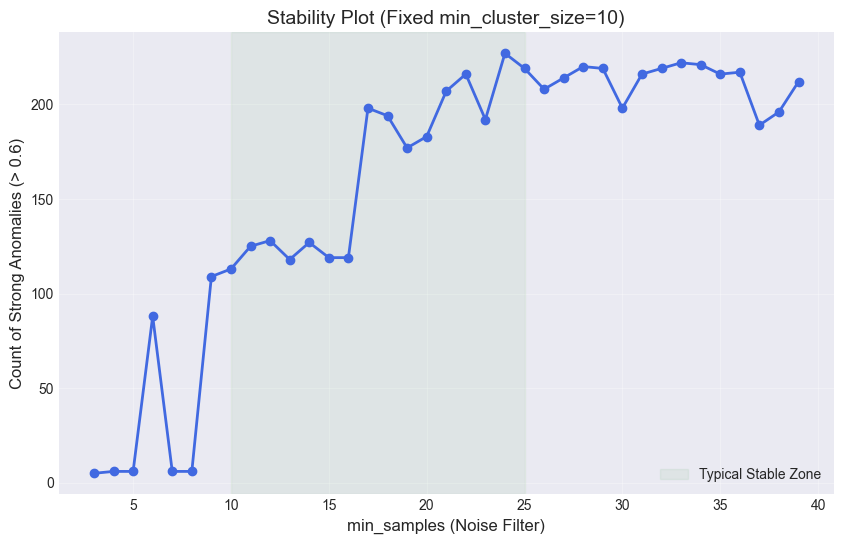

[(3, 5),
 (4, 6),
 (5, 6),
 (6, 88),
 (7, 6),
 (8, 6),
 (9, 109),
 (10, 113),
 (11, 125),
 (12, 128),
 (13, 118),
 (14, 127),
 (15, 119),
 (16, 119),
 (17, 198),
 (18, 194),
 (19, 177),
 (20, 183),
 (21, 207),
 (22, 216),
 (23, 192),
 (24, 227),
 (25, 219),
 (26, 208),
 (27, 214),
 (28, 220),
 (29, 219),
 (30, 198),
 (31, 216),
 (32, 219),
 (33, 222),
 (34, 221),
 (35, 216),
 (36, 217),
 (37, 189),
 (38, 196),
 (39, 212)]

In [38]:
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import warnings

def hdbscan_study_fixed_size(X, min_cluster_size=10, min_samples_range=range(3, 40)):
    """
    Runs HDBSCAN with a fixed min_cluster_size and varying min_samples.
    Returns the anomaly counts to help identify the 'Stability Plateau'.
    """
    warnings.filterwarnings('ignore')
    
    results = []
    
    # Iterate ONLY over min_samples
    for min_samples in min_samples_range:
        
        # 1. Initialize and Fit
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size, # FIXED at 10
            min_samples=min_samples,           # VARYING
            metric='euclidean',
            cluster_selection_method='eom', 
            allow_single_cluster=True
        )
        
        clusterer.fit(X)
        
        # 2. Calculate Anomalies (Robust Threshold Method)
        # We use a fixed scientific threshold (0.8) to see how the model behavior changes.
        # If we used a percentile (e.g. top 1%), the count would be constant, hiding the physics.
        scores = clusterer.outlier_scores_
        threshold = 0.60
        
        anomaly_indices = np.where(scores > threshold)[0]
        count = len(anomaly_indices)
        
        results.append((min_samples, count))
        print(f"min_samples={min_samples} -> Found {count} anomalies (Score > {threshold})")

    # Unpack for plotting
    x_vals = [r[0] for r in results]
    y_vals = [r[1] for r in results]

    # 3. Plot the Curve
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, y_vals, 'o-', linewidth=2, color='royalblue')
    
    # Add visual guide for the "Plateau"
    plt.xlabel('min_samples (Noise Filter)', fontsize=12)
    plt.ylabel(f'Count of Strong Anomalies (> {threshold})', fontsize=12)
    plt.title(f'Stability Plot (Fixed min_cluster_size={min_cluster_size})', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Highlight the likely optimal zone (visual aid)
    plt.axvspan(10, 25, color='green', alpha=0.05, label='Typical Stable Zone')
    plt.legend()
    
    plt.show()
    
    return results

hdbscan_study_fixed_size(X)
# --- USAGE ---
# results = hdbscan_study_fixed_size(my_features, min_cluster_size=10)

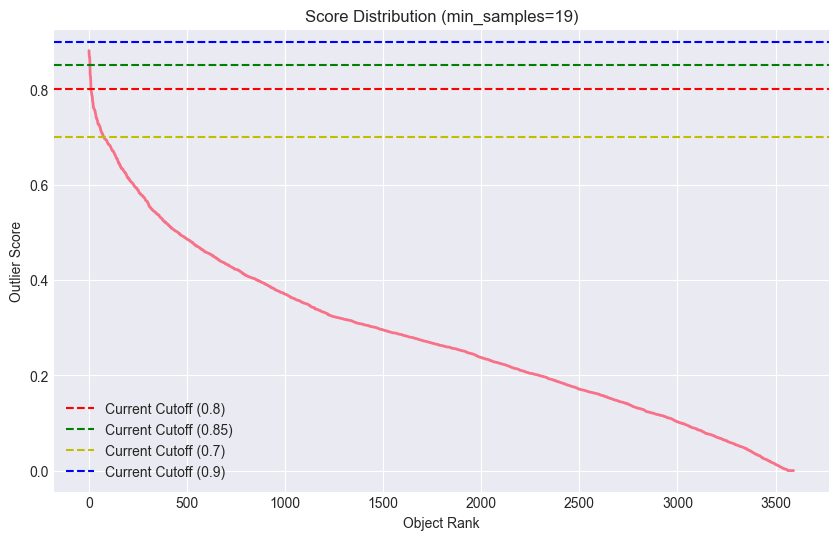

In [39]:
import matplotlib.pyplot as plt
import numpy as np

min_cluster_size=10 # FIXED at 10
min_samples = 24

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size, # FIXED at 10
    min_samples=min_samples,           # VARYING
    # metric='euclidean',
    cluster_selection_method='eom', 
    allow_single_cluster=True
)

clusterer.fit(X)
# Use your trained clusterer
scores = clusterer.outlier_scores_

# Sort scores high to low
sorted_scores = np.sort(scores)[::-1]

plt.figure(figsize=(10, 6))
plt.plot(sorted_scores, linewidth=2)
plt.axhline(y=0.8, color='r', linestyle='--', label='Current Cutoff (0.8)')
plt.axhline(y=0.85, color='g', linestyle='--', label='Current Cutoff (0.85)')
plt.axhline(y=0.7, color='y', linestyle='--', label='Current Cutoff (0.7)')
plt.axhline(y=0.9, color='b', linestyle='--', label='Current Cutoff (0.9)')
plt.ylabel("Outlier Score")
plt.xlabel("Object Rank")
plt.title("Score Distribution (min_samples=19)")
plt.legend()
plt.show()

In [40]:
threshold = 0.6

anomaly_indices = np.where(scores > threshold)[0]
# count = len(anomaly_indices)

print(f"""For min_samples = {min_samples}, min_cluster_size = {min_cluster_size}, threshold = {threshold}, epoch = {start_epoch}, the size of anomalies = {len(anomaly_indices)}""")
# print(anomaly_indices)
indices = np.array(latent_label[anomaly_indices]).flatten()
list2 = [int(i) for i in sorted(indices)]

# For min_samples = 12, min_cluster_size = 10, threshold = 0.8, epoch = 320, the size of anomalies = 173
# For min_samples = 25, min_cluster_size = 10, threshold = 0.8, epoch = 1000, the size of anomalies = 165

# For min_samples = 20, min_cluster_size = 10, threshold = 0.6, epoch = 600, the size of anomalies = 145
# For min_samples = 25, min_cluster_size = 10, threshold = 0.6, epoch = 500, the size of anomalies = 178



For min_samples = 24, min_cluster_size = 10, threshold = 0.6, epoch = 800, the size of anomalies = 227


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Create and fit the Isolation Forest model
# clf = IsolationForest(contamination=0.1)
clf = IsolationForest(contamination=0.0749, n_estimators=1000, random_state=42)
clf.fit(X)

# Predict anomalies
y_pred = clf.predict(X)

indices_raw = np.where(y_pred == -1 )
indices = np.array(latent_label[indices_raw])
indices = indices.flatten()
print(len(indices))
print(sorted(indices))
print([int(i) for i in sorted(indices)])
list3 = [int(i) for i in sorted(indices)]

#  - 100
# [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 110, 111, 112, 113, 119, 120, 124, 140, 141, 142, 146, 149, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 181, 200, 207, 209, 210, 211, 215, 217, 218, 221, 223, 224, 225, 226, 243, 247, 257, 296, 297, 298, 300, 304, 307, 308, 309, 313, 314, 344, 345, 352, 357, 361, 362, 367, 373, 477, 488, 591, 594, 597, 611, 615, 616, 618, 619, 627, 628, 630, 631, 633, 639, 648, 651, 656, 657, 663, 665, 768, 799, 965, 980, 991, 996, 1003, 1007, 1048, 1051, 1052, 1066, 1072, 1075, 1146, 1164, 1196, 1226, 1227, 1234, 1244, 1255, 1268, 1270, 1284, 1318, 1326, 1327, 1440, 1443, 1445, 1455, 1464, 1470, 1477, 1497, 1498, 1500, 1501, 1505, 1506, 1508, 1510, 1512, 1513, 1514, 1515, 1518, 1522, 1525, 1527, 1578, 1584, 1599, 1602, 1623, 1655, 1671, 1674, 1679, 1701, 1721, 1726, 1748, 1817, 1920, 1927, 1938, 1939, 1940, 1943, 1951, 1956, 1961, 1980, 1993, 2014, 2193, 2412, 2587, 2620, 2622, 2665, 2829, 2840, 2848, 2876, 2896, 2914, 2926, 2970, 2983, 2987, 3020, 3035, 3038, 3072, 3076, 3077, 3169, 3175, 3176, 3180, 3189, 3194, 3196, 3198, 3201, 3204, 3206, 3210, 3215, 3228, 3239, 3240, 3245, 3248, 3251, 3259, 3273, 3282, 3284, 3313, 3374, 3375, 3376, 3401, 3409, 3427, 3432, 3437, 3440, 3442, 3445, 3446, 3459, 3463, 3467, 3479, 3488, 3496, 3498, 3499, 3503, 3506, 3509, 3513, 3527, 3528, 3530, 3532, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3543, 3544, 3545, 3548, 3551, 3552, 3553, 3554, 3557, 3558, 3559, 3560, 3563, 3566, 3568, 3569]
# - 300
# [1, 2, 6, 10, 11, 14, 17, 19, 27, 33, 36, 52, 53, 57, 60, 62, 63, 66, 67, 68, 70, 71, 72, 79, 80, 82, 87, 116, 125, 129, 130, 134, 135, 148, 149, 153, 159, 175, 180, 181, 190, 193, 194, 197, 198, 199, 200, 201, 203, 206, 214, 215, 217, 224, 225, 226, 227, 243, 247, 252, 258, 259, 260, 267, 271, 278, 281, 284, 286, 288, 298, 300, 302, 307, 314, 315, 328, 329, 343, 346, 350, 352, 357, 367, 375, 378, 411, 422, 423, 427, 445, 484, 511, 521, 566, 581, 582, 586, 598, 601, 623, 645, 658, 661, 664, 688, 698, 704, 729, 735, 745, 751, 757, 763, 767, 769, 772, 776, 779, 785, 795, 809, 814, 818, 870, 881, 886, 888, 900, 918, 925, 960, 964, 968, 976, 991, 995, 998, 1000, 1002, 1008, 1025, 1030, 1039, 1053, 1062, 1085, 1100, 1115, 1139, 1164, 1175, 1184, 1191, 1227, 1234, 1244, 1255, 1270, 1271, 1284, 1305, 1306, 1310, 1314, 1329, 1357, 1397, 1408, 1417, 1421, 1423, 1467, 1485, 1490, 1508, 1514, 1526, 1532, 1542, 1552, 1572, 1588, 1630, 1632, 1637, 1641, 1642, 1719, 1731, 1739, 1746, 1758, 1783, 1785, 1832, 1844, 1869, 1888, 1892, 1893, 1902, 1906, 1930, 1932, 1933, 2028, 2039, 2062, 2098, 2207, 2208, 2214, 2215, 2228, 2242, 2254, 2266, 2279, 2280, 2286, 2297, 2307, 2311, 2312, 2323, 2325, 2326, 2336, 2350, 2352, 2360, 2363, 2381, 2382, 2398, 2399, 2422, 2433, 2447, 2460, 2471, 2473, 2477, 2481, 2484, 2489, 2490, 2509, 2519, 2521, 2526, 2528, 2529, 2530, 2539, 2569, 2585, 2586, 2587, 2596, 2597, 2599, 2665, 2703, 2724, 2726, 2834, 2837, 2853, 2881, 2892, 2968, 2976, 2977, 3007, 3057, 3065, 3070, 3121, 3135, 3175, 3180, 3181, 3187, 3194, 3196, 3203, 3207, 3210, 3215, 3216, 3237, 3239, 3242, 3251, 3256, 3262, 3271, 3282, 3287, 3301, 3311, 3319, 3327, 3348, 3352, 3359, 3362, 3392, 3396, 3398, 3406, 3421, 3427, 3451, 3460, 3467, 3530, 3541, 3555, 3569, 3588, 3592]
# - 600
# [2, 6, 14, 17, 34, 36, 44, 52, 53, 54, 58, 63, 65, 70, 80, 82, 116, 125, 130, 134, 135, 146, 148, 149, 159, 162, 166, 168, 176, 189, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 214, 215, 217, 220, 222, 225, 226, 252, 259, 278, 279, 284, 298, 300, 301, 302, 305, 314, 323, 326, 328, 331, 343, 346, 349, 350, 352, 367, 423, 427, 445, 454, 468, 469, 484, 518, 521, 534, 543, 566, 581, 586, 594, 601, 605, 623, 629, 636, 645, 649, 658, 661, 664, 667, 688, 703, 705, 729, 734, 735, 757, 763, 766, 785, 795, 814, 818, 826, 869, 881, 888, 900, 948, 964, 968, 991, 995, 1027, 1066, 1074, 1077, 1085, 1100, 1115, 1116, 1119, 1124, 1126, 1140, 1144, 1155, 1163, 1164, 1169, 1186, 1187, 1191, 1198, 1214, 1215, 1218, 1225, 1227, 1231, 1233, 1234, 1244, 1255, 1257, 1266, 1268, 1271, 1274, 1276, 1284, 1306, 1331, 1357, 1369, 1397, 1403, 1408, 1417, 1467, 1478, 1485, 1509, 1526, 1536, 1538, 1542, 1543, 1552, 1554, 1588, 1631, 1637, 1642, 1676, 1731, 1745, 1769, 1849, 1888, 1897, 1932, 1933, 2027, 2039, 2098, 2167, 2214, 2215, 2228, 2254, 2276, 2280, 2286, 2311, 2312, 2323, 2333, 2341, 2345, 2350, 2355, 2359, 2382, 2394, 2397, 2398, 2399, 2407, 2417, 2422, 2429, 2447, 2471, 2477, 2489, 2496, 2502, 2504, 2519, 2526, 2528, 2529, 2530, 2585, 2586, 2587, 2665, 2703, 2714, 2825, 2835, 2846, 2849, 2851, 2852, 2853, 2858, 2877, 2881, 2883, 2884, 2885, 2888, 2892, 2899, 2901, 2908, 2914, 2924, 2968, 2973, 2976, 2977, 2991, 3013, 3019, 3026, 3041, 3046, 3050, 3051, 3057, 3063, 3065, 3126, 3135, 3148, 3169, 3191, 3207, 3214, 3215, 3216, 3229, 3230, 3237, 3239, 3241, 3246, 3253, 3256, 3261, 3262, 3267, 3274, 3287, 3311, 3314, 3319, 3327, 3330, 3334, 3338, 3341, 3348, 3352, 3357, 3359, 3362, 3368, 3382, 3396, 3398, 3401, 3408, 3421, 3423, 3426, 3427, 3432, 3437, 3443, 3449, 3451, 3460, 3464, 3519, 3530, 3569]


270
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70), np.int64(78

In [ ]:
set_all = set.intersection(*(set(lst) for lst in [list2, list3]))

print(len(set_all))
print(sorted(set_all))
print(sorted([all_labels[sub_index] for sub_index in set_all]))
anomaly_names = sorted([all_labels[sub_index] for sub_index in set_all])



204
[2, 6, 14, 34, 36, 44, 52, 63, 70, 78, 80, 116, 130, 134, 135, 149, 159, 197, 203, 215, 216, 225, 226, 227, 234, 252, 259, 269, 278, 284, 288, 295, 298, 300, 304, 314, 326, 328, 343, 349, 352, 378, 411, 422, 433, 445, 454, 484, 521, 534, 543, 566, 586, 601, 622, 623, 634, 645, 649, 658, 667, 688, 705, 706, 735, 757, 769, 785, 814, 818, 881, 900, 921, 968, 991, 995, 1066, 1077, 1085, 1116, 1126, 1186, 1234, 1244, 1271, 1331, 1357, 1423, 1467, 1478, 1526, 1542, 1543, 1544, 1588, 1631, 1637, 1642, 1731, 1769, 1888, 1898, 1932, 1968, 2039, 2098, 2139, 2214, 2215, 2254, 2280, 2311, 2312, 2323, 2333, 2341, 2345, 2350, 2355, 2363, 2382, 2399, 2422, 2447, 2471, 2477, 2489, 2490, 2519, 2521, 2530, 2569, 2570, 2585, 2586, 2587, 2665, 2703, 2714, 2825, 2846, 2849, 2851, 2853, 2859, 2875, 2877, 2881, 2883, 2884, 2892, 2901, 2905, 2914, 2924, 2937, 2941, 2944, 2948, 2950, 2968, 2973, 2976, 2977, 2982, 2993, 3002, 3013, 3019, 3023, 3041, 3046, 3050, 3051, 3057, 3058, 3061, 3063, 3065, 3135, 3145

In [41]:
o1 = ['2018eny', '2018eph', '2018fxj', '2018gum', '2018gxi', '2018hib', '2018hka', '2018hkx', '2018hql', '2018huc', '2018izr', '2018jgq', '2018jkg', '2018jms', '2018kah', '2018kao', '2018kjp', '2019ajf', '2019alj', '2019bap', '2019bcp', '2019bea', '2019bgo', '2019bgp', '2019cmb', '2019cqi', '2019dns', '2019erz', '2019esl', '2019fis', '2019gn', '2019gzu', '2019hlb', '2019hnp', '2019iiv', '2019kh', '2019kli', '2019lo', '2019nfv', '2019nvm', '2019pco', '2019pzj', '2019saz', '2019sld', '2019sse', '2019tsu', '2019ufy', '2019vzy', '2019xe', '2020aacy', '2020aayk', '2020abbx', '2020acpv', '2020aem', '2020aewf', '2020afq', '2020btp', '2020bvg', '2020bxc', '2020chm', '2020csx', '2020cxd', '2020dyu', '2020dzi', '2020eyb', '2020ftl', '2020fyf', '2020ghu', '2020hef', '2020hgp', '2020hvq', '2020iwn', '2020kav', '2020mez', '2020ocw', '2020rkb', '2020uvg', '2020wnf', '2020zo', '2021aalc', '2021acet', '2021adsn', '2021afte', '2021afth', '2021afvw', '2021agoa', '2021bll', '2021bma', '2021cmf', '2021css', '2021cxp', '2021dvt', '2021flg', '2021ieq', '2021kei', '2021kox', '2021ksl', '2021qpb', '2021qxb', '2021soz', '2021ttz', '2021xet', '2021xgy', '2021xhf', '2021xmj', '2021xob', '2021xpn', '2021yib', '2021yic', '2021yuh', '2021zba', '2021zco', '2021zeu', '2021zf', '2022amx', '2022bbk', '2022bzq', '2022cdv', '2022cfp', '2022chy', '2022djv', '2022dma', '2022dnw', '2022dsv', '2022dtp', '2022duk', '2022efc', '2022ejx', '2022emm', '2022eoa', '2022eqe', '2022ezj', '2022kh']
o2 = ['2018emt', '2018eny', '2018fbm', '2018fxj', '2018fxl', '2018gty', '2018gum', '2018jms', '2018jwi', '2018kao', '2018kbi', '2018kfv', '2018kif', '2018kjp', '2018kuv', '2018kwm', '2018lla', '2018lot', '2019abb', '2019abc', '2019ait', '2019ajf', '2019alb', '2019alj', '2019atc', '2019bfd', '2019bvp', '2019cjz', '2019con', '2019cow', '2019coz', '2019crx', '2019crz', '2019cwr', '2019dfr', '2019dhm', '2019dtv', '2019dut', '2019dzc', '2019ehx', '2019ekk', '2019ekn', '2019esa', '2019gdy', '2019gqv', '2019gws', '2019hit', '2019hlb', '2019hnp', '2019hpg', '2019hsc', '2019hyu', '2019iiv', '2019kli', '2019krj', '2019lph', '2019lpr', '2019lpw', '2019mpq', '2019mqc', '2019muu', '2019mzo', '2019njr', '2019njy', '2019nty', '2019nwu', '2019nzq', '2019pla', '2019qck', '2019qey', '2019qgh', '2019qoj', '2019qqk', '2019qty', '2019rre', '2019saz', '2019sld', '2019slj', '2019sqo', '2019sxb', '2019sxc', '2019tat', '2019til', '2019tjl', '2019tlu', '2019tsy', '2019tvu', '2019uge', '2019uje', '2019ukb', '2019vyb', '2019vyf', '2019xe', '2019zsi', '2020aacy', '2020aayc', '2020abfo', '2020afq', '2020akf', '2020aoi', '2020bbt', '2020bjq', '2020bxc', '2020ddu', '2020dnf', '2020fcw', '2020fjs', '2020fqv', '2020ftl', '2020gbb', '2020hhc', '2020hij', '2020hlh', '2020hvq', '2020ilw', '2020ish', '2020jxq', '2020kq', '2020lfw', '2020liy', '2020lpz', '2020lqd', '2020mfz', '2020mqq', '2020mtr', '2020mud', '2020ocw', '2020ptv', '2020qir', '2020rtt', '2020rxo', '2020tgq', '2020wd', '2020xyw', '2020yf', '2020ywq', '2020ywu', '2020yyt', '2021aaxr', '2021abwn', '2021acyl', '2021ageo', '2021agfn', '2021cby', '2021cya', '2021djx', '2021gbp', '2021hcx', '2021ife', '2021kky', '2021klj', '2021muw', '2021nwt', '2021nwu', '2021oim', '2021soz', '2021stc', '2021udg', '2021uef', '2021wkx', '2021yzg', '2022efb', '2022eg', '2022emm', '2022sr']
o2 = ['2018eny', '2018eph', '2018fxj', '2018gum', '2018gxi', '2018hdo', '2018hib', '2018hka', '2018hkx', '2018hps', '2018hql', '2018hsf', '2018huc', '2018izr', '2018jkg', '2018jms', '2018jwi', '2018kao', '2018kfv', '2018kjp', '2019ajf', '2019alj', '2019bap', '2019bcp', '2019bea', '2019bet', '2019bfb', '2019bgo', '2019bgp', '2019cmb', '2019cqi', '2019dhz', '2019dns', '2019ebe', '2019erz', '2019esl', '2019fis', '2019gn', '2019gzu', '2019hnp', '2019hpg', '2019htx', '2019iiv', '2019kh', '2019kli', '2019lo', '2019lru', '2019mqc', '2019mzo', '2019nfv', '2019nng', '2019nvm', '2019pco', '2019pzj', '2019saz', '2019sld', '2019sse', '2019tfd', '2019tsu', '2019ufy', '2019vzy', '2019xe', '2019yek', '2020aacy', '2020aayk', '2020abbx', '2020acpv', '2020adw', '2020aek', '2020aem', '2020aewf', '2020afq', '2020bmp', '2020bol', '2020btp', '2020bvg', '2020bxc', '2020chi', '2020chm', '2020csx', '2020cxd', '2020dyu', '2020dzi', '2020eee', '2020eyb', '2020ezz', '2020fra', '2020ftl', '2020fyf', '2020ghu', '2020gzr', '2020hef', '2020hgp', '2020iwn', '2020kav', '2020lkf', '2020lqd', '2020mez', '2020mic', '2020ocw', '2020rkb', '2020rxw', '2020si', '2020tn', '2020uvg', '2020wnf', '2020wvh', '2021aalc', '2021acet', '2021adsn', '2021afte', '2021afth', '2021afvw', '2021agoa', '2021bll', '2021bma', '2021cmf', '2021css', '2021cxp', '2021dvt', '2021efn', '2021flg', '2021gfy', '2021ieq', '2021ife', '2021kei', '2021kil', '2021kox', '2021ksl', '2021odw', '2021qpb', '2021qxb', '2021soz', '2021xet', '2021xhf', '2021xku', '2021xmj', '2021xnb', '2021xni', '2021xob', '2021xpn', '2021yhc', '2021yib', '2021yic', '2021ylu', '2021yuh', '2021zbt', '2021zco', '2021zf', '2022amx', '2022blz', '2022bwe', '2022bzq', '2022cdv', '2022cfp', '2022chy', '2022csi', '2022djv', '2022dnw', '2022dsv', '2022dtp', '2022efc', '2022eg', '2022ejx', '2022emm', '2022ezj', '2022fdw', '2022kh', '2022zr']

set_all = set.intersection(*(set(lst) for lst in [o1, o2]))


print(len(set_all))
print(sorted(set_all))

# 24
# ['2018fxl', '2018lla', '2018lot', '2019bfd', '2019bvp', '2019cow', '2019dtv', '2019esa', '2019hlb', '2019kli', '2019lph', '2019muu', '2019njr', '2019tjl', '2020aacy', '2020fjs', '2020ftl', '2020hij', '2020ilw', '2020rtt', '2020tgq', '2021gbp', '2021nwt', '2022sr']
# 39
# ['2018fxl', '2018lla', '2018lot', '2019bfd', '2019bvp', '2019cow', '2019coz', '2019dtv', '2019esa', '2019hit', '2019hlb', '2019kli', '2019krj', '2019lph', '2019mpq', '2019muu', '2019njr', '2019njy', '2019pla', '2019qey', '2019tat', '2019tjl', '2019tlu', '2020aacy', '2020afq', '2020fjs', '2020fqv', '2020ftl', '2020hij', '2020ilw', '2020liy', '2020rtt', '2020tgq', '2021ageo', '2021gbp', '2021kky', '2021nwt', '2021soz', '2022sr']

# 119
# ['2018eny', '2018eph', '2018fxj', '2018gum', '2018gxi', '2018hib', '2018hka', '2018hkx', '2018hql', '2018huc', '2018izr', '2018jkg', '2018jms', '2018kao', '2018kjp', '2019ajf', '2019alj', '2019bap', '2019bcp', '2019bea', '2019bgo', '2019bgp', '2019cmb', '2019cqi', '2019dns', '2019erz', '2019esl', '2019fis', '2019gn', '2019gzu', '2019hnp', '2019iiv', '2019kh', '2019kli', '2019lo', '2019nfv', '2019nvm', '2019pco', '2019pzj', '2019saz', '2019sld', '2019sse', '2019tsu', '2019ufy', '2019vzy', '2019xe', '2020aacy', '2020aayk', '2020abbx', '2020acpv', '2020aem', '2020aewf', '2020afq', '2020btp', '2020bvg', '2020bxc', '2020chm', '2020csx', '2020cxd', '2020dyu', '2020dzi', '2020eyb', '2020ftl', '2020fyf', '2020ghu', '2020hef', '2020hgp', '2020iwn', '2020kav', '2020mez', '2020ocw', '2020rkb', '2020uvg', '2020wnf', '2021aalc', '2021acet', '2021adsn', '2021afte', '2021afth', '2021afvw', '2021agoa', '2021bll', '2021bma', '2021cmf', '2021css', '2021cxp', '2021dvt', '2021flg', '2021ieq', '2021kei', '2021kox', '2021ksl', '2021qpb', '2021qxb', '2021soz', '2021xet', '2021xhf', '2021xmj', '2021xob', '2021xpn', '2021yib', '2021yic', '2021yuh', '2021zco', '2021zf', '2022amx', '2022bzq', '2022cdv', '2022cfp', '2022chy', '2022djv', '2022dnw', '2022dsv', '2022dtp', '2022efc', '2022ejx', '2022emm', '2022ezj', '2022kh']


119
['2018eny', '2018eph', '2018fxj', '2018gum', '2018gxi', '2018hib', '2018hka', '2018hkx', '2018hql', '2018huc', '2018izr', '2018jkg', '2018jms', '2018kao', '2018kjp', '2019ajf', '2019alj', '2019bap', '2019bcp', '2019bea', '2019bgo', '2019bgp', '2019cmb', '2019cqi', '2019dns', '2019erz', '2019esl', '2019fis', '2019gn', '2019gzu', '2019hnp', '2019iiv', '2019kh', '2019kli', '2019lo', '2019nfv', '2019nvm', '2019pco', '2019pzj', '2019saz', '2019sld', '2019sse', '2019tsu', '2019ufy', '2019vzy', '2019xe', '2020aacy', '2020aayk', '2020abbx', '2020acpv', '2020aem', '2020aewf', '2020afq', '2020btp', '2020bvg', '2020bxc', '2020chm', '2020csx', '2020cxd', '2020dyu', '2020dzi', '2020eyb', '2020ftl', '2020fyf', '2020ghu', '2020hef', '2020hgp', '2020iwn', '2020kav', '2020mez', '2020ocw', '2020rkb', '2020uvg', '2020wnf', '2021aalc', '2021acet', '2021adsn', '2021afte', '2021afth', '2021afvw', '2021agoa', '2021bll', '2021bma', '2021cmf', '2021css', '2021cxp', '2021dvt', '2021flg', '2021ieq', '2021kei

# Re Construction Error Anomaly Detection

In [ ]:
def detect_anomalies_with_weights(model, data_loader, threshold_percentile=95, device='cuda'):
    """
    Detect anomalies based on weighted reconstruction error
    Weights are per time step (batch_size, seq_len), not per feature
    """
    model.eval()
    all_recon_errors = []
    all_ids = []
    all_labels = []
    all_original_data = []
    all_reconstructed_data = []
    all_sequence_lengths = []
    # all_weights = []
    
    # max_seq_len = 58  # Assuming this is your fixed padding length
    max_seq_len = max([all_data[item].shape[0] for item in range(len(all_data))])

    with torch.no_grad():
        for x, uncertainties, weights, labels, ids, lengths in data_loader:
            x = x.to(device)
            
            # Get reconstruction
            x_hat, mu, logvar = model(x, lengths)
            
            # Store original and reconstructed data
            original_batch = x.cpu().numpy()
            reconstructed_batch = x_hat.cpu().numpy()

            # Ensure all sequences have the same length (58)
            # They should already be padded by DataLoader
            batch_size = original_batch.shape[0]
            if original_batch.shape[1] != max_seq_len:
                # Pad or truncate to max_seq_len
                padded_original = np.zeros((batch_size, max_seq_len, original_batch.shape[2]))
                padded_reconstructed = np.zeros((batch_size, max_seq_len, reconstructed_batch.shape[2]))
                
                for i in range(batch_size):
                    seq_len = min(original_batch.shape[1], max_seq_len)
                    padded_original[i, :seq_len] = original_batch[i, :seq_len]
                    padded_reconstructed[i, :seq_len] = reconstructed_batch[i, :seq_len]
                
                original_batch = padded_original
                reconstructed_batch = padded_reconstructed

            # Compute reconstruction error per time step and feature
            # (batch_size, seq_len, features)
            squared_error = (x_hat - x) ** 2
            
            # Handle weights - they are per time step
            if weights is not None:
                # Weights have shape (batch_size, seq_len)
                # We need to expand to match (batch_size, seq_len, features)
                weights = weights.to(device)
                
                # Add feature dimension and expand to match x shape
                weights_expanded = weights.unsqueeze(-1)  # (batch_size, seq_len, 1)
                weights_expanded = weights_expanded.expand_as(x)  # (batch_size, seq_len, features)
                
                # Apply weights to squared error
                weighted_error = weights_expanded * squared_error
            else:
                weighted_error = squared_error
            
            # Average across time steps and features for each sample
            # This gives one reconstruction error score per sample
            recon_error = torch.mean(weighted_error, dim=(1, 2)).cpu().numpy()
            
            all_recon_errors.extend(recon_error)
            all_ids.extend(ids)
            all_labels.extend(labels.cpu().numpy())

            all_original_data.extend(original_batch)
            all_reconstructed_data.extend(reconstructed_batch)
            all_sequence_lengths.extend(lengths.cpu().numpy())

    
    # Convert to numpy arrays
    all_recon_errors = np.array(all_recon_errors)
    all_original_data = np.array(all_original_data)
    all_reconstructed_data = np.array(all_reconstructed_data)
    all_sequence_lengths = np.array(all_sequence_lengths)
    all_labels = np.array(all_labels)

    # Set threshold based on percentile
    threshold = np.percentile(all_recon_errors, threshold_percentile)
    
    # Identify anomalies
    is_anomaly = all_recon_errors > threshold
    
    # Create results dictionary
    results = {
        'ids': all_ids,
        'reconstruction_errors': all_recon_errors,
        'anomaly_predictions': is_anomaly,
        'threshold': threshold,
        'labels': all_labels,
        'original_data': all_original_data,
        'reconstructed_data': all_reconstructed_data,
        'sequence_lengths': all_sequence_lengths,
        'weights': all_weights,
        'threshold_percentile': threshold_percentile
    }
    
    return results


# Reconstruction Error Anomaly Detection Analysis By Epochs


### Sensitivity Analysis


Processing epoch 100...
Resumed training from epoch 100
  Epoch 100: Mean reconstruction error = 0.9056

Processing epoch 200...
Resumed training from epoch 200
  Epoch 200: Mean reconstruction error = 0.6632

Processing epoch 300...
Resumed training from epoch 300
  Epoch 300: Mean reconstruction error = 0.4808

Processing epoch 400...
Resumed training from epoch 400
  Epoch 400: Mean reconstruction error = 0.3954

Processing epoch 500...
Resumed training from epoch 500
  Epoch 500: Mean reconstruction error = 0.3636

Processing epoch 600...
Resumed training from epoch 600
  Epoch 600: Mean reconstruction error = 0.3106

Processing epoch 700...
Resumed training from epoch 700
  Epoch 700: Mean reconstruction error = 0.2702

Processing epoch 800...
Resumed training from epoch 800
  Epoch 800: Mean reconstruction error = 0.2514

Processing epoch 900...
Resumed training from epoch 900
  Epoch 900: Mean reconstruction error = 0.2392

Processing epoch 1000...
Resumed training from epoch 1

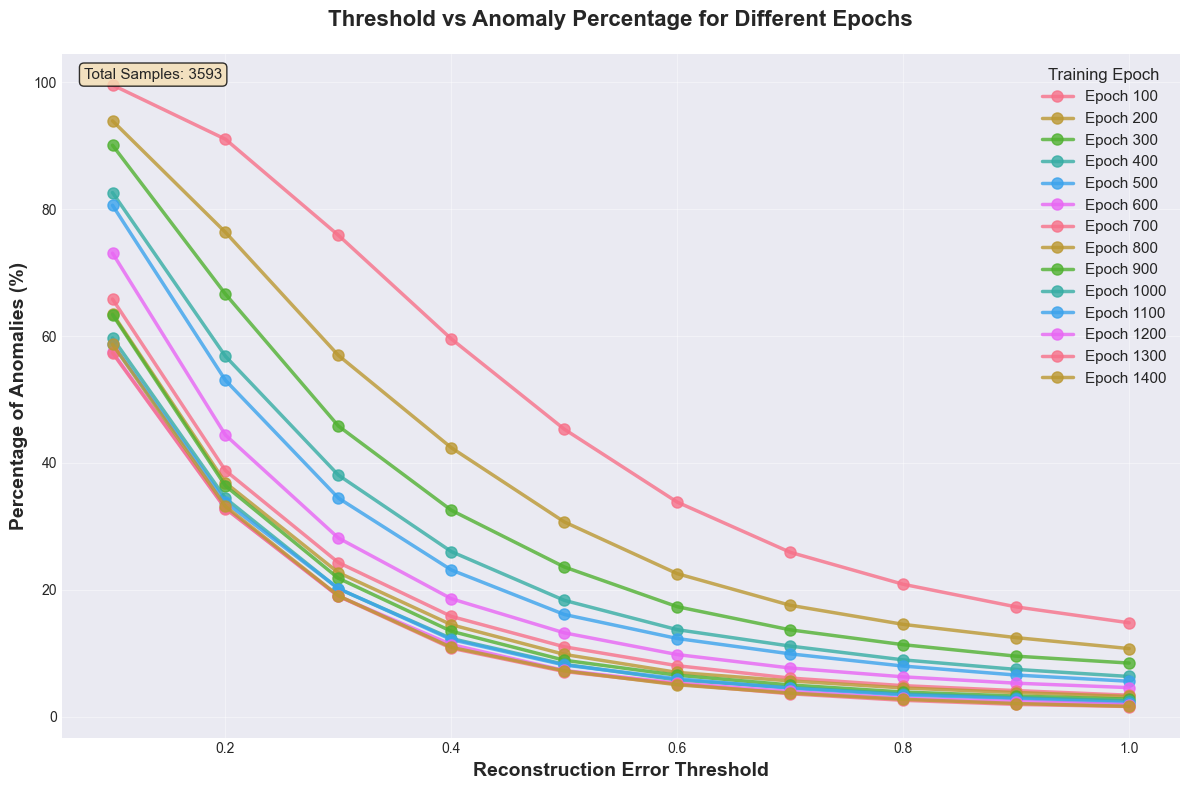

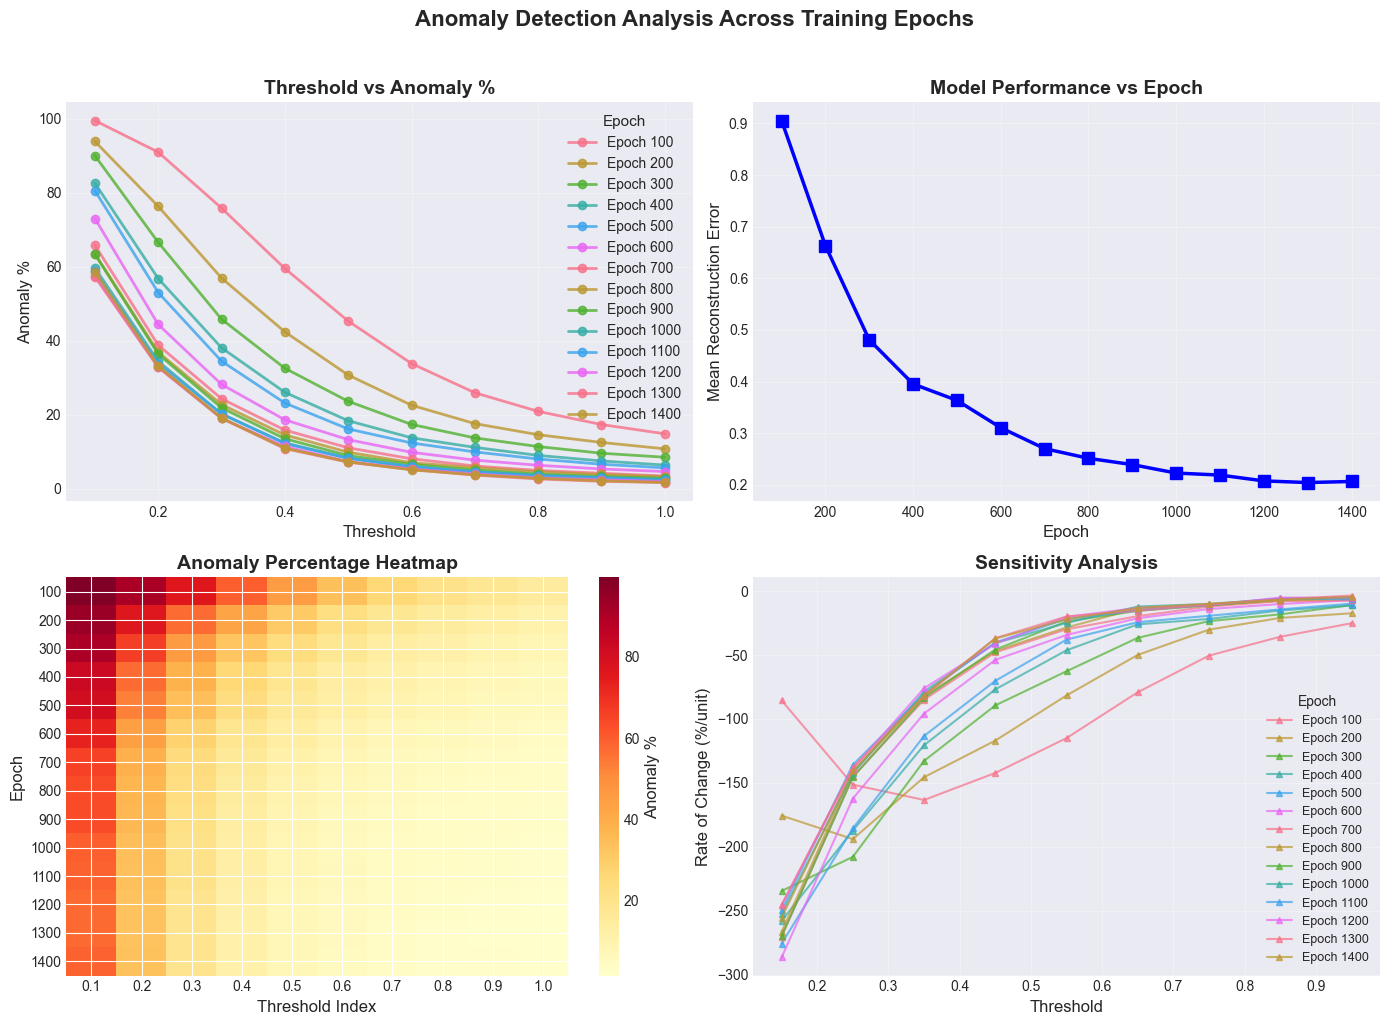


SUMMARY TABLE: Anomaly Percentages by Epoch and Threshold
Epoch     0.1     0.2     0.3     0.4     0.5     0.6     0.7     0.8     0.9     1.0     MeanErr 
--------------------------------------------------------------------------------
100        99.6%   91.0%   75.9%   59.5%   45.3%   33.8%   25.9%   20.9%   17.3%   14.8%  0.9056  
200        93.9%   76.3%   56.9%   42.4%   30.7%   22.5%   17.6%   14.6%   12.5%   10.7%  0.6632  
300        90.1%   66.6%   45.8%   32.5%   23.6%   17.3%   13.7%   11.4%    9.5%    8.5%  0.4808  
400        82.6%   56.8%   38.1%   26.0%   18.3%   13.7%   11.1%    9.0%    7.5%    6.3%  0.3954  
500        80.6%   53.0%   34.5%   23.1%   16.1%   12.3%    9.9%    8.0%    6.6%    5.6%  0.3636  
600        73.1%   44.4%   28.2%   18.6%   13.2%    9.8%    7.7%    6.3%    5.3%    4.6%  0.3106  
700        65.8%   38.8%   24.3%   15.8%   11.0%    8.0%    6.1%    4.9%    4.1%    3.4%  0.2702  
800        63.5%   36.9%   22.7%   14.5%    9.8%    7.0%    5.6%    

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.util import resume_training


# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Prepare data storage
epoch_results = {}
threshold_values = np.arange(0.1, 1.01, 0.1)  # From 0.1 to 1.0 in steps of 0.1
epochs_to_check = range(100, 1401, 100)

# Loop through epochs
for epoch in epochs_to_check:
    print(f"\nProcessing epoch {epoch}...")
    
    # Resume training and get model state
    start_epoch, training_losses, validation_losses = resume_training(
        f'{checkpoint_path}/RNN_VAE_checkpoint_epoch{epoch}.pth', model, optimizer
    )
    
    # Detect anomalies
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)
    
    # Calculate percentage of anomalies for each threshold
    percentages = []
    total_samples = len(results['reconstruction_errors'])
    
    for threshold in threshold_values:
        anomaly_indices = np.where(results['reconstruction_errors'] > threshold)[0]
        percentage = len(anomaly_indices) / total_samples * 100
        percentages.append(percentage)
    
    # Store results
    epoch_results[epoch] = {
        'thresholds': threshold_values,
        'percentages': np.array(percentages),
        'total_samples': total_samples,
        'model_error_mean': results['reconstruction_errors'].mean(),
        'model_error_std': results['reconstruction_errors'].std()
    }
    
    print(f"  Epoch {epoch}: Mean reconstruction error = {epoch_results[epoch]['model_error_mean']:.4f}")

# Create overlay plot
plt.figure(figsize=(12, 8))

# Plot each epoch's curve
for epoch in epochs_to_check:
    plt.plot(epoch_results[epoch]['thresholds'], 
             epoch_results[epoch]['percentages'],
             marker='o', 
             linewidth=2.5,
             markersize=8,
             label=f'Epoch {epoch}',
             alpha=0.8)

# Customize plot
plt.xlabel('Reconstruction Error Threshold', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of Anomalies (%)', fontsize=14, fontweight='bold')
plt.title('Threshold vs Anomaly Percentage for Different Epochs', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(title='Training Epoch', title_fontsize=12, fontsize=11, loc='best')
plt.grid(True, alpha=0.4)

# Add annotation for total samples
total_samples = epoch_results[epochs_to_check[0]]['total_samples']
plt.annotate(f'Total Samples: {total_samples}', 
             xy=(0.02, 0.98), xycoords='axes fraction',
             fontsize=11, ha='left', va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Create subplot with additional analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Main overlay plot (top-left)
ax1 = axes[0, 0]
for epoch in epochs_to_check:
    ax1.plot(epoch_results[epoch]['thresholds'], 
             epoch_results[epoch]['percentages'],
             marker='o', linewidth=2, markersize=6,
             label=f'Epoch {epoch}', alpha=0.8)
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Anomaly %', fontsize=12)
ax1.set_title('Threshold vs Anomaly %', fontsize=14, fontweight='bold')
ax1.legend(title='Epoch', fontsize=10, title_fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Model performance vs epoch (top-right)
ax2 = axes[0, 1]
mean_errors = [epoch_results[epoch]['model_error_mean'] for epoch in epochs_to_check]
ax2.plot(epochs_to_check, mean_errors, 'b-', marker='s', linewidth=2.5, markersize=8)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Reconstruction Error', fontsize=12)
ax2.set_title('Model Performance vs Epoch', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Heatmap of anomaly percentages (bottom-left)
ax3 = axes[1, 0]
# Create matrix for heatmap
heatmap_data = np.array([epoch_results[epoch]['percentages'] for epoch in epochs_to_check])
im = ax3.imshow(heatmap_data, aspect='auto', cmap='YlOrRd')
ax3.set_xlabel('Threshold Index', fontsize=12)
ax3.set_ylabel('Epoch', fontsize=12)
ax3.set_title('Anomaly Percentage Heatmap', fontsize=14, fontweight='bold')
ax3.set_xticks(range(len(threshold_values)))
ax3.set_xticklabels([f'{t:.1f}' for t in threshold_values])
ax3.set_yticks(range(len(epochs_to_check)))
ax3.set_yticklabels([f'{e}' for e in epochs_to_check])

# Add colorbar
cbar = plt.colorbar(im, ax=ax3)
cbar.set_label('Anomaly %', fontsize=12)

# 4. Rate of change (bottom-right)
ax4 = axes[1, 1]
for epoch in epochs_to_check:
    percentages = epoch_results[epoch]['percentages']
    rate_of_change = np.diff(percentages) / np.diff(threshold_values)
    mid_points = (threshold_values[:-1] + threshold_values[1:]) / 2
    ax4.plot(mid_points, rate_of_change, marker='^', linewidth=1.5, 
             markersize=5, label=f'Epoch {epoch}', alpha=0.7)
ax4.set_xlabel('Threshold', fontsize=12)
ax4.set_ylabel('Rate of Change (%/unit)', fontsize=12)
ax4.set_title('Sensitivity Analysis', fontsize=14, fontweight='bold')
ax4.legend(title='Epoch', fontsize=9, title_fontsize=10)
ax4.grid(True, alpha=0.3)

plt.suptitle('Anomaly Detection Analysis Across Training Epochs', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Create summary table
print("\n" + "="*80)
print("SUMMARY TABLE: Anomaly Percentages by Epoch and Threshold")
print("="*80)

# Header
header = "Epoch".ljust(8)
for thresh in threshold_values:
    header += f"  {thresh:.1f}".ljust(8)
header += "  MeanErr".ljust(10)
print(header)
print("-" * 80)

# Data rows
for epoch in epochs_to_check:
    row = f"{epoch}".ljust(8)
    for i, thresh in enumerate(threshold_values):
        pct = epoch_results[epoch]['percentages'][i]
        row += f"  {pct:5.1f}%".ljust(8)
    mean_err = epoch_results[epoch]['model_error_mean']
    row += f"  {mean_err:.4f}".ljust(10)
    print(row)

print("="*80)

# Save data for further analysis
import pickle

analysis_data = {
    'epoch_results': epoch_results,
    'threshold_values': threshold_values,
    'epochs_to_check': list(epochs_to_check)
}

with open('anomaly_threshold_analysis.pkl', 'wb') as f:
    pickle.dump(analysis_data, f)
print(f"\nAnalysis data saved to 'anomaly_threshold_analysis.pkl'")

# Create interactive plot (if using Jupyter)
try:
    from ipywidgets import interact, widgets
    
    @interact(epoch=widgets.Dropdown(
        options=list(epochs_to_check),
        value=list(epochs_to_check)[0],
        description='Epoch:'
    ))
    def plot_interactive(epoch):
        fig, ax = plt.subplots(figsize=(10, 6))
        
        ax.plot(epoch_results[epoch]['thresholds'], 
                epoch_results[epoch]['percentages'],
                'b-', marker='o', linewidth=2.5, markersize=8)
        
        ax.set_xlabel('Reconstruction Error Threshold', fontsize=12)
        ax.set_ylabel('Percentage of Anomalies (%)', fontsize=12)
        ax.set_title(f'Epoch {epoch}: Threshold vs Anomaly Percentage\n'
                    f'Mean Error: {epoch_results[epoch]["model_error_mean"]:.4f}', 
                    fontsize=14)
        ax.grid(True, alpha=0.3)
        
        # Add threshold markers
        for thresh, pct in zip(epoch_results[epoch]['thresholds'], 
                               epoch_results[epoch]['percentages']):
            ax.annotate(f'{pct:.1f}%', 
                       xy=(thresh, pct),
                       xytext=(0, 10),
                       textcoords='offset points',
                       ha='center',
                       fontsize=9,
                       alpha=0.7)
        
        plt.tight_layout()
        plt.show()
    
    print("\nInteractive plot available. Use the dropdown to select different epochs.")
except ImportError:
    print("\nNote: Install ipywidgets for interactive plots: pip install ipywidgets")

### end

<>:9: SyntaxWarning: invalid escape sequence '\R'
<>:9: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_38196\1670094384.py:9: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58
Resumed training from epoch 900
Epoch 900 - Padded length: 58
Resumed training from epoch 1000
Epoch 1000 - Padded length: 58
Resumed training from epoch 1100
Epoch 1100 - Padded length: 58
Resumed training from epoch 1200
Epoch 1200 - Padded length: 58
Resumed training from epoch 1300
Epoch 1300 - Padded length: 58
Resumed training from epoch 1400
Epoch 1400 - Padded length: 58


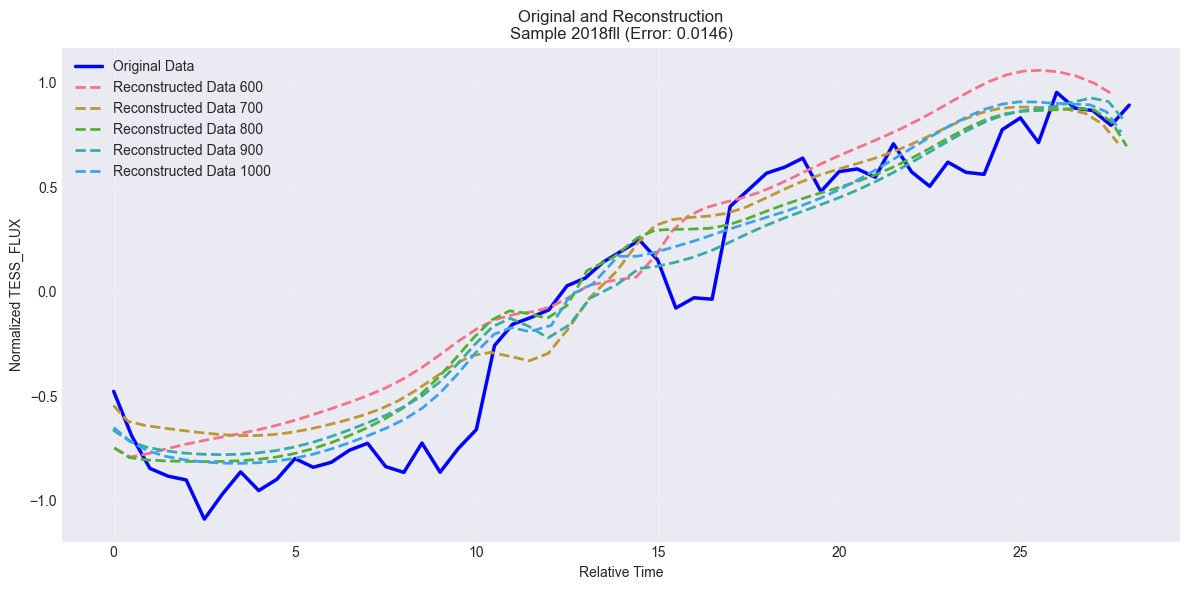

In [26]:
label_name = '2019pkz'
label_name = '2021iff'
label_name = '2018fll'

recon_data_all = {}
orig_data = []

for epochs in range(600, 1401, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data

# Minimalist clean overlap plot
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    if epochs > 1000:
        continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()

In [27]:
checkpoint_path

WindowsPath('checkpoint/RNN_VAE_lat16_hid128_gru4_norm_uncert_15m')

<>:7: SyntaxWarning: invalid escape sequence '\R'
<>:7: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_38196\1476939758.py:7: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58
Resumed training from epoch 900
Epoch 900 - Padded length: 58
Resumed training from epoch 1000
Epoch 1000 - Padded length: 58


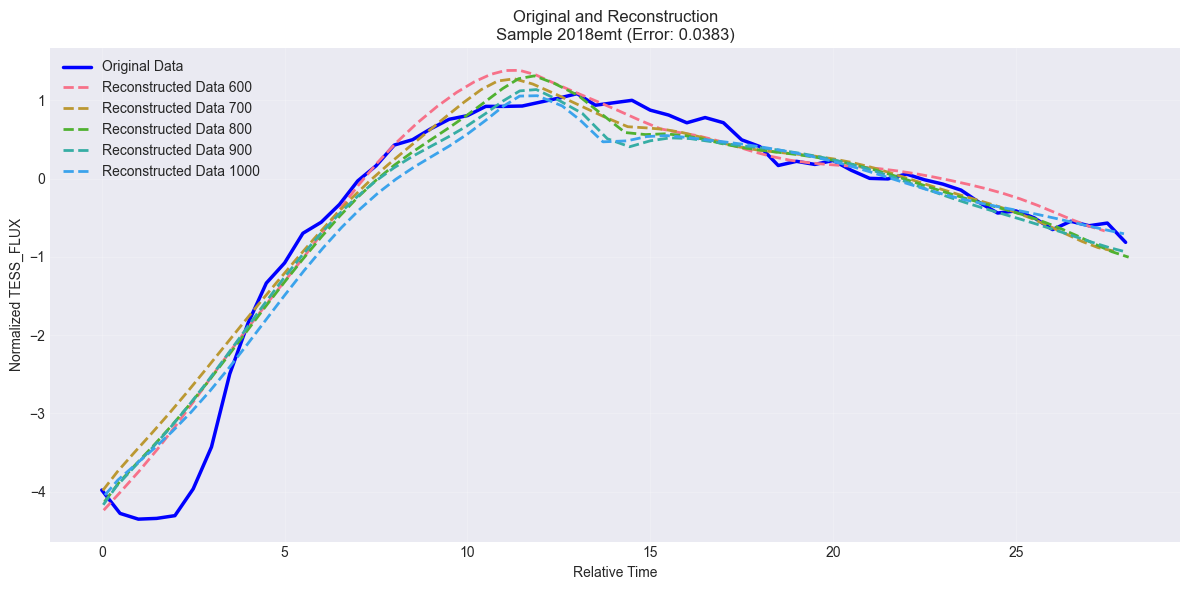

In [28]:
label_name = '2018emt'

recon_data_all = {}
orig_data = []

for epochs in range(600, 1001, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data

# Minimalist clean overlap plot
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    if epochs > 1000:
        continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\R'
<>:8: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_38196\2024321072.py:8: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 400
Epoch 400 - Padded length: 58
Resumed training from epoch 500
Epoch 500 - Padded length: 58
Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58


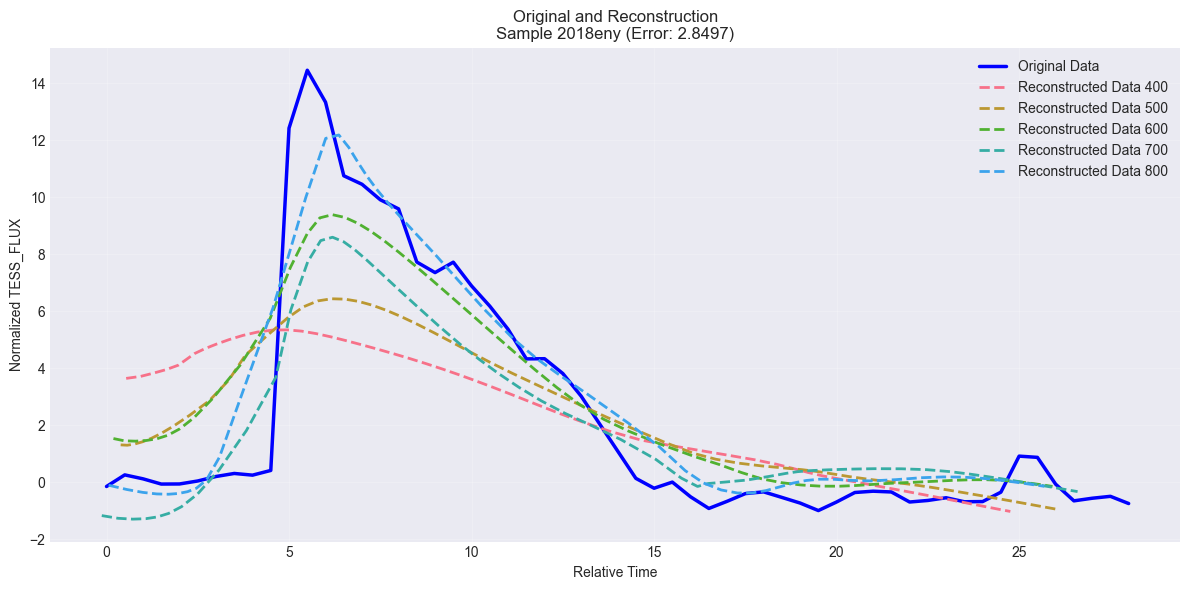

In [29]:
label_name = '2018hql'
label_name = '2018eny'

recon_data_all = {}
orig_data = []

for epochs in range(400, 801, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data

# Minimalist clean overlap plot
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    if epochs > 1000:
        continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\R'
<>:7: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_38196\3113879493.py:7: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 400
Epoch 400 - Padded length: 58
Resumed training from epoch 500
Epoch 500 - Padded length: 58
Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58


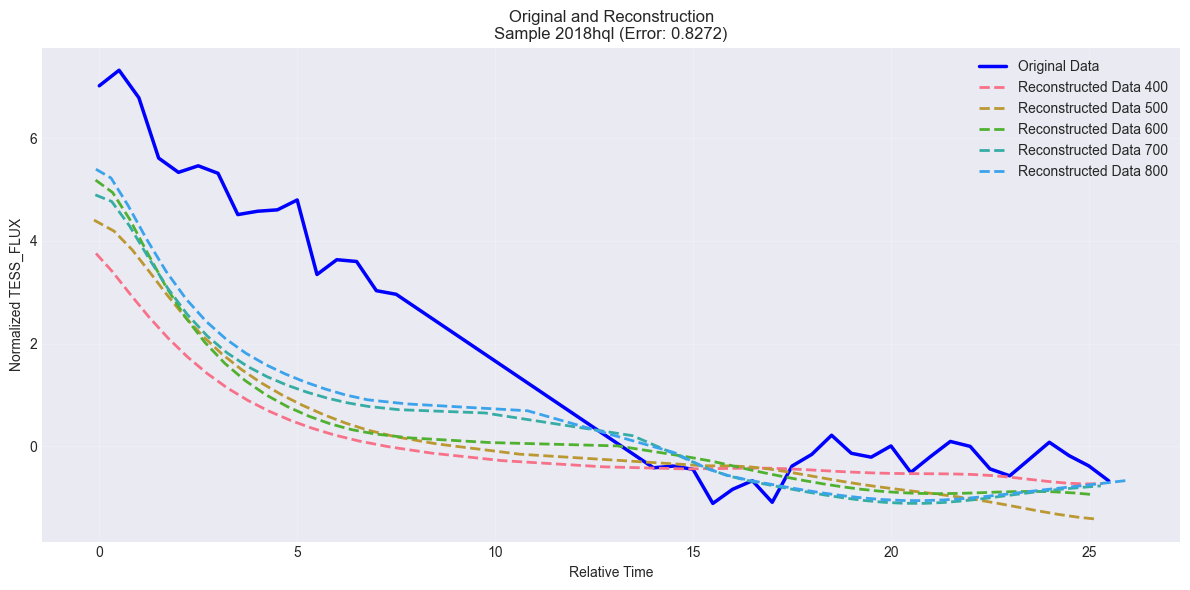

In [30]:
label_name = '2018hql'

recon_data_all = {}
orig_data = []

for epochs in range(400, 801, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data# Minimalist clean overlap plot
    
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    if epochs > 1000:
        continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()


<>:6: SyntaxWarning: invalid escape sequence '\R'
<>:6: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_38196\2141878098.py:6: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58
Resumed training from epoch 900
Epoch 900 - Padded length: 58
Resumed training from epoch 1000
Epoch 1000 - Padded length: 58
Resumed training from epoch 1100
Epoch 1100 - Padded length: 58
Resumed training from epoch 1200
Epoch 1200 - Padded length: 58
Resumed training from epoch 1300
Epoch 1300 - Padded length: 58
Resumed training from epoch 1400
Epoch 1400 - Padded length: 58


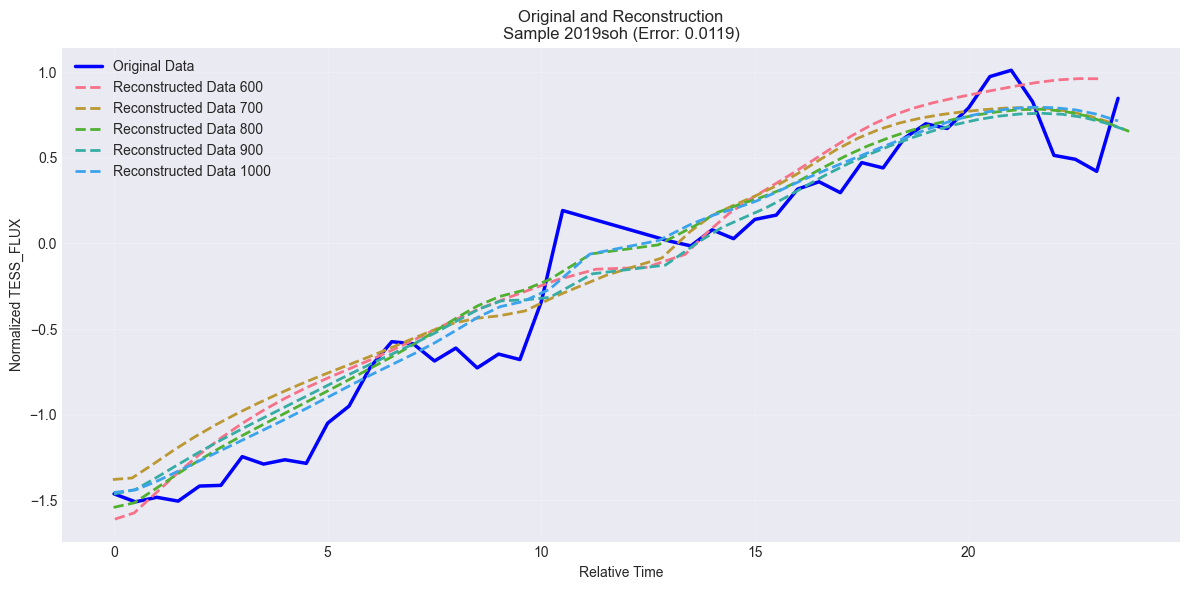

In [31]:
label_name = '2019soh'
recon_data_all = {}
orig_data = []

for epochs in range(600, 1401, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data# Minimalist clean overlap plot
    
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    if epochs > 1000:
        continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()


<>:6: SyntaxWarning: invalid escape sequence '\R'
<>:6: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_38196\1237339169.py:6: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 600
Epoch 600 - Padded length: 58
Resumed training from epoch 700
Epoch 700 - Padded length: 58
Resumed training from epoch 800
Epoch 800 - Padded length: 58
Resumed training from epoch 900
Epoch 900 - Padded length: 58
Resumed training from epoch 1000
Epoch 1000 - Padded length: 58
Resumed training from epoch 1100
Epoch 1100 - Padded length: 58
Resumed training from epoch 1200
Epoch 1200 - Padded length: 58
Resumed training from epoch 1300
Epoch 1300 - Padded length: 58
Resumed training from epoch 1400
Epoch 1400 - Padded length: 58


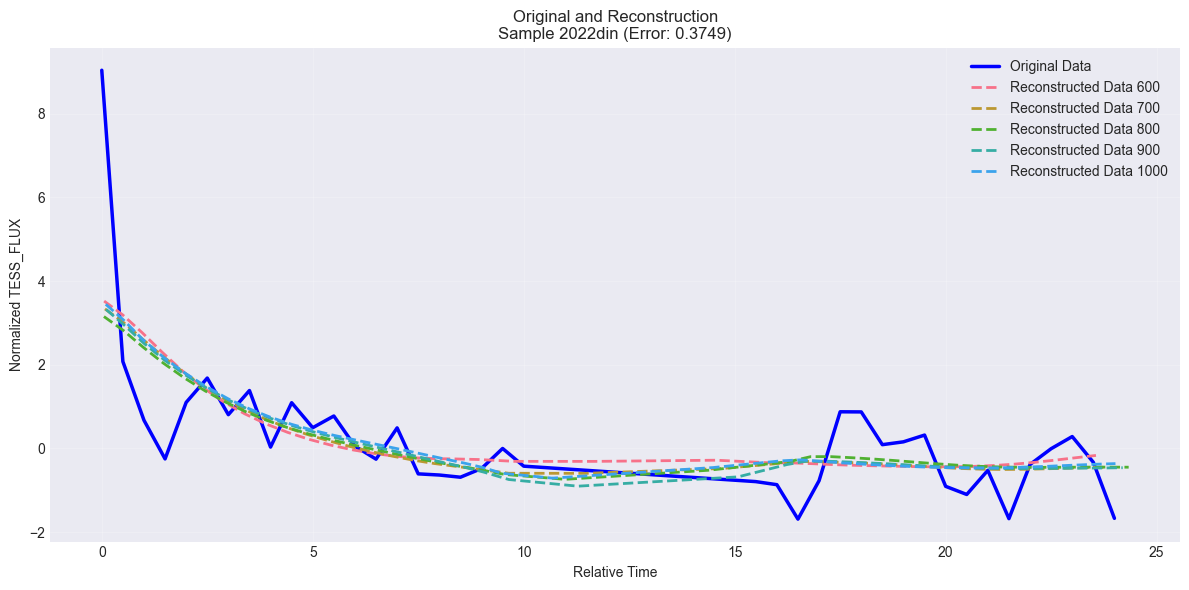

In [32]:
label_name = '2022din'
recon_data_all = {}
orig_data = []

for epochs in range(600, 1401, 100):
    start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)
    results = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device=device)

    recon_all_ids = [results['ids'][i].item() for i in range(len(results['ids']))]
    anomaly_index = recon_all_ids.index(all_labels.index(label_name))
    seq_length = results['sequence_lengths'][anomaly_index]  # Get actual length before padding

    print(f"Epoch {epochs} - Padded length: {len(results['original_data'][anomaly_index])}")
    orig_data = results['original_data'][anomaly_index][:seq_length]  # Remove padding
    recon_data = results['reconstructed_data'][anomaly_index][:seq_length]  # Remove padding

    recon_data_all[epochs] = recon_data# Minimalist clean overlap plot
    
plt.figure(figsize=(12, 6))

# Plot with minimal styling
plt.plot(orig_data[:, 0], orig_data[:, 1], 'b-', linewidth=2.5, label='Original Data')

for epochs in recon_data_all.keys():
    if epochs > 1000:
        continue;
    recon_data = recon_data_all[epochs]
    plt.plot(recon_data[:, 0], recon_data[:, 1], linewidth=2, linestyle='--', label=f'Reconstructed Data {epochs}')

plt.xlabel('Relative Time')
plt.ylabel('Normalized TESS_FLUX')
plt.title(f'Original and Reconstruction\nSample {label_name} (Error: {results["reconstruction_errors"][anomaly_index]:.4f})')
plt.legend()
plt.grid(True, alpha=0.2)


plt.tight_layout()
plt.show()


## end sensitivity study plot (extreme factor)

In [26]:
checkpoint_path


WindowsPath('checkpoint/RNN_VAE_lat16_hid128_gru4_norm_uncert_15m')

In [33]:
epochs = 700
start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)

results  = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device='cuda')

anomaly_indices = np.where(results['reconstruction_errors'] > 0.5)[0]
# print(anomaly_indices)
print(len(anomaly_indices))

all_indices = sorted([results['ids'][anomaly_index] for anomaly_index in anomaly_indices])
print(all_indices)

label_names = [all_labels[label_index] for label_index in all_indices]
print(label_names)

label_names_700 = label_names

<>:2: SyntaxWarning: invalid escape sequence '\R'
<>:2: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_38196\3733352390.py:2: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 700
398
[tensor(2), tensor(6), tensor(13), tensor(14), tensor(17), tensor(34), tensor(36), tensor(44), tensor(50), tensor(52), tensor(70), tensor(80), tensor(81), tensor(91), tensor(112), tensor(116), tensor(128), tensor(134), tensor(135), tensor(147), tensor(149), tensor(154), tensor(159), tensor(165), tensor(197), tensor(203), tensor(212), tensor(215), tensor(216), tensor(226), tensor(243), tensor(246), tensor(252), tensor(253), tensor(269), tensor(270), tensor(278), tensor(294), tensor(298), tensor(300), tensor(304), tensor(310), tensor(312), tensor(314), tensor(316), tensor(317), tensor(326), tensor(328), tensor(343), tensor(349), tensor(359), tensor(362), tensor(378), tensor(411), tensor(433), tensor(445), tensor(454), tensor(469), tensor(470), tensor(484), tensor(513), tensor(526), tensor(527), tensor(534), tensor(543), tensor(581), tensor(586), tensor(601), tensor(622), tensor(623), tensor(634), tensor(643), tensor(649), tensor(650), tensor(658), tens

In [34]:
epochs = 800
start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)

results  = detect_anomalies_with_weights(model, all_loader, threshold_percentile=95, device='cuda')

anomaly_indices = np.where(results['reconstruction_errors'] > 0.5)[0]
# print(anomaly_indices)
print(len(anomaly_indices))

all_indices = sorted([results['ids'][anomaly_index].tolist() for anomaly_index in anomaly_indices])
print(all_indices)

label_names = [all_labels[label_index] for label_index in all_indices]
print(label_names)

label_names_800 = label_names

<>:2: SyntaxWarning: invalid escape sequence '\R'
<>:2: SyntaxWarning: invalid escape sequence '\R'
C:\Users\xuesh\AppData\Local\Temp\ipykernel_38196\1457601683.py:2: SyntaxWarning: invalid escape sequence '\R'
  start_epoch, training_losses, validation_losses = resume_training(f'{checkpoint_path}\RNN_VAE_checkpoint_epoch{epochs}.pth', model, optimizer)


Resumed training from epoch 800
353
[2, 13, 14, 17, 34, 36, 44, 52, 80, 81, 91, 112, 116, 134, 135, 147, 149, 154, 159, 165, 197, 203, 212, 215, 226, 243, 246, 252, 253, 259, 269, 270, 278, 294, 298, 300, 304, 310, 312, 314, 316, 317, 328, 343, 346, 349, 411, 433, 454, 469, 470, 484, 526, 527, 543, 566, 581, 586, 601, 622, 623, 643, 645, 649, 650, 661, 662, 667, 669, 680, 685, 687, 688, 705, 712, 714, 718, 723, 724, 729, 735, 757, 771, 790, 801, 814, 818, 854, 877, 880, 881, 900, 921, 923, 948, 980, 986, 995, 999, 1014, 1022, 1026, 1034, 1043, 1058, 1059, 1061, 1063, 1074, 1075, 1077, 1085, 1087, 1097, 1113, 1116, 1126, 1144, 1149, 1158, 1186, 1221, 1234, 1244, 1271, 1275, 1286, 1292, 1302, 1303, 1306, 1331, 1334, 1365, 1383, 1397, 1423, 1443, 1459, 1467, 1507, 1542, 1543, 1544, 1549, 1566, 1582, 1588, 1615, 1631, 1675, 1676, 1682, 1731, 1745, 1748, 1759, 1760, 1761, 1767, 1768, 1769, 1773, 1779, 1781, 1790, 1795, 1796, 1797, 1818, 1822, 1849, 1897, 1898, 1921, 1932, 1933, 1946, 1958, 

In [48]:
# m3 = ['2018eny', '2018fdw', '2018fwm', '2018gku', '2018glq', '2018hql', '2018hyq', '2018iwl', '2018jkg', '2018jms', '2018jwj', '2018kao', '2018kgg', '2018kjp', '2019ajf', '2019cml', '2019cqi', '2019dov', '2019erz', '2019fir', '2019gdc', '2019gn', '2019guh', '2019gvc', '2019gzu', '2019hlb', '2019iiv', '2019pwd', '2019sld', '2019soj', '2019sxb', '2019tsu', '2019tsw', '2019uag', '2019ubf', '2019ufu', '2019ujt', '2019vzx', '2019vzy', '2019zdo', '2020aaqm', '2020acaj', '2020acge', '2020acna', '2020acpu', '2020adsx', '2020aefv', '2020aem', '2020aera', '2020ats', '2020axn', '2020bdk', '2020bh', '2020bmc', '2020btp', '2020bvg', '2020bxc', '2020bz', '2020cxd', '2020cym', '2020dcx', '2020ddi', '2020fld', '2020fyf', '2020hlr', '2020iwn', '2020jcb', '2020jej', '2020kav', '2020kcw', '2020lkf', '2020ndn', '2020nmu', '2020nyb', '2020rub', '2020sri', '2020xew', '2020xfd', '2020xgy', '2020xix', '2020xjp', '2020xmb', '2020xoy', '2020xyi', '2020yws', '2020zti', '2021aalc', '2021aavy', '2021aawy', '2021aaxr', '2021aboj', '2021abti', '2021abtx', '2021aero', '2021afth', '2021afvw', '2021afwe', '2021agis', '2021any', '2021bnd', '2021caf', '2021cby', '2021ctx', '2021cxp', '2021dvt', '2021eei', '2021egg', '2021eps', '2021gvp', '2021hfv', '2021ijh', '2021kbu', '2021kei', '2021kzb', '2021nmj', '2021oim', '2021pfg', '2021rde', '2021rip', '2021rth', '2021sjb', '2021sla', '2021soz', '2021tql', '2021ttz', '2021txl', '2021ues', '2021ufo', '2021uuz', '2021vxf', '2021yps', '2022ast', '2022avh', '2022axf', '2022bbk', '2022bzz', '2022ciz', '2022cmr', '2022cok', '2022cox', '2022csi', '2022dmr', '2022dni', '2022dtc', '2022dus', '2022emm', '2022eoa', '2022gaz', '2022oz', '2022tr']
# m15 = ['2018eny', '2018fdw', '2018fdx', '2018fhw', '2018fwm', '2018fxj', '2018glq', '2018gum', '2018hql', '2018hrs', '2018hyq', '2018iwl', '2018izr', '2018jkg', '2018jms', '2018jwj', '2018kao', '2018kgg', '2018kjp', '2018krw', '2019ajf', '2019alv', '2019ayy', '2019bcp', '2019bgp', '2019caa', '2019cix', '2019cmb', '2019cml', '2019dfr', '2019dhm', '2019dns', '2019ehx', '2019erz', '2019esl', '2019fir', '2019gdc', '2019gdy', '2019gn', '2019guh', '2019gvc', '2019hnp', '2019iiv', '2019kag', '2019mqc', '2019nng', '2019obp', '2019osx', '2019osz', '2019pco', '2019qck', '2019qcu', '2019qoj', '2019rvh', '2019saz', '2019sld', '2019src', '2019sse', '2019tdi', '2019tjl', '2019tjs', '2019tng', '2019tq', '2019tsu', '2019tsw', '2019ubf', '2019uem', '2019ufu', '2019ufy', '2019umq', '2019vbj', '2019vcz', '2019vkn', '2019vmb', '2019vmc', '2019vyf', '2019vzy', '2019xe', '2019zej', '2020aajq', '2020aaqm', '2020aayk', '2020abbx', '2020acaj', '2020acna', '2020acpu', '2020acpv', '2020adsx', '2020adth', '2020adtr', '2020aefv', '2020aera', '2020aeux', '2020afq', '2020akw', '2020ats', '2020azg', '2020bbe', '2020bdk', '2020bh', '2020blv', '2020bly', '2020bmf', '2020bms', '2020btp', '2020bud', '2020bvg', '2020bxc', '2020bz', '2020cdq', '2020cqk', '2020cxd', '2020ddi', '2020dra', '2020dsl', '2020dwy', '2020exn', '2020fmz', '2020ftl', '2020fyf', '2020hgp', '2020hgz', '2020hko', '2020hlr', '2020hsr', '2020hsv', '2020hvq', '2020iwn', '2020jej', '2020kcw', '2020kur', '2020lkf', '2020mic', '2020ndn', '2020nmu', '2020nrl', '2020pha', '2020rkb', '2020rld', '2020rme', '2020rub', '2020sri', '2020tir', '2020ubc', '2020uic', '2020vkb', '2020vku', '2020voy', '2020wnf', '2020wvh', '2020wwz', '2020xel', '2020xew', '2020xfd', '2020xgu', '2020xgy', '2020xgz', '2020xho', '2020xix', '2020xjp', '2020xmb', '2020xoy', '2020xpa', '2020xpi', '2020xyi', '2020yac', '2020yu', '2020zti', '2020zui', '2021aaen', '2021aalc', '2021aanc', '2021aarc', '2021aavy', '2021aawy', '2021aazx', '2021abet', '2021abfd', '2021abfm', '2021aboj', '2021abti', '2021acet', '2021adjy', '2021aeba', '2021aecx', '2021aedf', '2021aejw', '2021aere', '2021aevw', '2021afte', '2021afth', '2021afvw', '2021afwe', '2021agjr', '2021agoa', '2021any', '2021bma', '2021bnd', '2021buu', '2021caf', '2021cby', '2021ckj', '2021cmf', '2021ctx', '2021cxp', '2021dac', '2021dvt', '2021eac', '2021eee', '2021efq', '2021egg', '2021eps', '2021ero', '2021fdo', '2021fvc', '2021gfy', '2021gvp', '2021hfv', '2021hhw', '2021hlg', '2021ijh', '2021jbh', '2021kbu', '2021kil', '2021ksl', '2021nev', '2021nmj', '2021odw', '2021oim', '2021qpb', '2021rlp', '2021sea', '2021seb', '2021soz', '2021ues', '2021uuz', '2021voq', '2021vxf', '2021wue', '2021xbn', '2021xet', '2021xgv', '2021xgy', '2021xhg', '2021xhm', '2021xhq', '2021xiw', '2021xjl', '2021xjq', '2021xkr', '2021xlz', '2021xmj', '2021xnm', '2021xns', '2021xny', '2021xph', '2021xqg', '2021xqh', '2021xqi', '2021xrc', '2021xrd', '2021xuk', '2021xvu', '2021xws', '2021xwt', '2021xxt', '2021xzu', '2021ybe', '2021ybj', '2021yfj', '2021yfy', '2021yga', '2021ygg', '2021yhc', '2021yib', '2021yif', '2021yiq', '2021yjr', '2021yko', '2021yln', '2021ylu', '2021ymy', '2021ync', '2021ynq', '2021yoc', '2021yps', '2021ypt', '2021yqa', '2021ysk', '2021yuh', '2021yvo', '2021yvr', '2021yxf', '2021yxp', '2021yxx', '2021yyd', '2021yyu', '2021yzg', '2021zba', '2021zct', '2021zdo', '2021zeu', '2022abk', '2022akw', '2022ami', '2022amx', '2022ark', '2022ash', '2022ast', '2022aua', '2022avh', '2022axf', '2022bbk', '2022bwb', '2022cad', '2022cdx', '2022chh', '2022chi', '2022chy', '2022ciz', '2022cmr', '2022cok', '2022dhl', '2022djv', '2022dni', '2022dnw', '2022dsv', '2022dtj', '2022dto', '2022duz', '2022ebu', '2022ee', '2022ejx', '2022ely', '2022eoa', '2022eyw', '2022fc', '2022gao', '2022gaz', '2022geo', '2022gw', '2022ln', '2022oz', '2022um']

# set_all = set.intersection(*(set(lst) for lst in [label_names_800, label_names_700]))
# set_all = set.intersection(*(set(lst) for lst in [m3, label_names_700]))
set_all = set.intersection(*(set(lst) for lst in [list2, list3, all_indices]))
# set_all = set.intersection(*(set(lst) for lst in [list2, list3]))


print(len(set_all))
print(sorted(set_all))

# 129
# [2, 14, 34, 36, 44, 52, 80, 116, 134, 135, 149, 159, 197, 203, 215, 226, 252, 259, 269, 278, 298, 300, 304, 314, 328, 343, 349, 411, 433, 454, 484, 543, 566, 586, 601, 622, 623, 645, 649, 667, 688, 705, 735, 757, 814, 818, 881, 921, 995, 1077, 1085, 1116, 1126, 1186, 1234, 1244, 1271, 1331, 1423, 1467, 1526, 1542, 1543, 1544, 1631, 1731, 1769, 1898, 1932, 2039, 2214, 2215, 2280, 2312, 2323, 2333, 2341, 2345, 2355, 2382, 2399, 2447, 2521, 2530, 2569, 2570, 2585, 2665, 2825, 2846, 2849, 2851, 2859, 2875, 2881, 2884, 2905, 2914, 2924, 2937, 2944, 2948, 2950, 2968, 2976, 2982, 2993, 3002, 3013, 3019, 3023, 3041, 3046, 3050, 3058, 3061, 3063, 3135, 3145, 3256, 3319, 3334, 3352, 3357, 3358, 3368, 3421, 3457, 3482]

# [2, 17, 36, 52, 80, 116, 134, 135, 149, 159, 197, 216, 252, 259, 298, 300, 314, 326, 328, 343, 349, 411, 427, 445, 484, 521, 601, 623, 667, 688, 735, 818, 881, 968, 1077, 1085, 1244, 1306, 1357, 1526, 1542, 1731, 1932, 2215, 2228, 2280, 2311, 2312, 2345, 2355, 2382, 2447, 2530, 2585, 2665, 2714, 2846, 2851, 2881, 2892, 2914, 2976, 3019, 3046, 3065, 3135, 3256, 3319, 3358, 3421]



116
[2, 14, 34, 36, 44, 52, 80, 116, 135, 149, 159, 197, 203, 215, 226, 259, 269, 298, 300, 314, 328, 343, 349, 411, 433, 454, 484, 543, 566, 586, 601, 622, 623, 649, 667, 688, 705, 735, 757, 814, 818, 881, 900, 921, 995, 1085, 1126, 1186, 1234, 1244, 1271, 1423, 1542, 1543, 1544, 1588, 1631, 1731, 1769, 1932, 2039, 2214, 2215, 2280, 2312, 2323, 2333, 2341, 2345, 2355, 2382, 2399, 2447, 2530, 2569, 2570, 2585, 2665, 2825, 2846, 2849, 2851, 2859, 2875, 2881, 2884, 2905, 2914, 2924, 2944, 2948, 2968, 2973, 2976, 2982, 2993, 3002, 3013, 3019, 3023, 3041, 3046, 3050, 3058, 3061, 3063, 3135, 3145, 3256, 3319, 3352, 3357, 3358, 3368, 3421, 3482]


In [67]:
129/350

0.36857142857142855

In [66]:
l1 = [2, 14, 34, 36, 44, 52, 80, 116, 134, 135, 149, 159, 197, 203, 215, 226, 252, 259, 269, 278, 298, 300, 304, 314, 328, 343, 349, 411, 433, 454, 484, 543, 566, 586, 601, 622, 623, 645, 649, 667, 688, 705, 735, 757, 814, 818, 881, 921, 995, 1077, 1085, 1116, 1126, 1186, 1234, 1244, 1271, 1331, 1423, 1467, 1526, 1542, 1543, 1544, 1631, 1731, 1769, 1898, 1932, 2039, 2214, 2215, 2280, 2312, 2323, 2333, 2341, 2345, 2355, 2382, 2399, 2447, 2521, 2530, 2569, 2570, 2585, 2665, 2825, 2846, 2849, 2851, 2859, 2875, 2881, 2884, 2905, 2914, 2924, 2937, 2944, 2948, 2950, 2968, 2976, 2982, 2993, 3002, 3013, 3019, 3023, 3041, 3046, 3050, 3058, 3061, 3063, 3135, 3145, 3256, 3319, 3334, 3352, 3357, 3358, 3368, 3421, 3457, 3482]
l2 = [2, 17, 36, 52, 80, 116, 134, 135, 149, 159, 197, 216, 252, 259, 298, 300, 314, 326, 328, 343, 349, 411, 427, 445, 484, 521, 601, 623, 667, 688, 735, 818, 881, 968, 1077, 1085, 1244, 1306, 1357, 1526, 1542, 1731, 1932, 2215, 2228, 2280, 2311, 2312, 2345, 2355, 2382, 2447, 2530, 2585, 2665, 2714, 2846, 2851, 2881, 2892, 2914, 2976, 3019, 3046, 3065, 3135, 3256, 3319, 3358, 3421]

set_all = set.intersection(*(set(lst) for lst in [l1, l2]))

print(len(set_all))
print(sorted(set_all))

# 129



56
[2, 36, 52, 80, 116, 134, 135, 149, 159, 197, 252, 259, 298, 300, 314, 328, 343, 349, 411, 484, 601, 623, 667, 688, 735, 818, 881, 1077, 1085, 1244, 1526, 1542, 1731, 1932, 2215, 2280, 2312, 2345, 2355, 2382, 2447, 2530, 2585, 2665, 2846, 2851, 2881, 2914, 2976, 3019, 3046, 3135, 3256, 3319, 3358, 3421]


# TESS Catalog

In [293]:
import pandas as pd

# Read the Excel file
df = pd.read_excel('tess_transient.xlsx', sheet_name=0)  # sheet_name=0 reads the first sheet

# Convert the entire DataFrame to a list of lists (each row becomes a list)
# data_list = df.values.tolist()
print(f"Unique names = {len(df['name'].unique())}")

df


Unique names = 17565


,Unnamed: 0,#sector,ra,dec,mag,disc_tjd,t1,type,name,group,cam,ccd,column,row
0,NaN,1,327.160083,-43.380019,17.800,1340.34000,SN,SNIa,2018evo,ASAS-SN,1,1,1860.105,322.643
1,NaN,1,315.033417,-40.358594,17.869,1341.92600,SN,SNIa,2018exc,ATLAS,1,1,528.652,1304.728
2,NaN,1,313.474583,-38.015594,18.781,1347.90100,SN,SNII,2018fgb,ATLAS,1,1,424.192,1751.547
3,NaN,1,312.964500,-36.837031,17.200,1362.63000,SN,SNIa,2018fqd,ASAS-SN,1,1,403.699,1967.303
4,NaN,1,336.090208,-33.692739,17.000,1361.57000,SN,SNIa,2018fpm,ASAS-SN,1,2,1484.443,1361.155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21104,NaN,92,1.304708,-11.506647,17.761,3803.64162,AT,Unclassified,2025kjo,"ATLAS,GOTO",4,3,75.388,185.414
21105,NaN,92,351.555421,5.023214,19.449,3811.98015,AT,Unclassified,2025ktm,ZTF,4,4,1286.504,648.957
21106,NaN,92,351.277708,1.775342,18.811,3814.97363,AT,Unclassified,2025ktf,ALeRCE,4,4,773.657,921.241
21107,NaN,92,346.357246,4.448933,18.525,3809.63649,AT,Unclassified,2025knf,ATLAS,4,4,1529.423,1527.312


In [177]:
names = df['name'].to_list()
Counter(names)

Counter({'2018glp': 3,
         '2018glq': 3,
         '2018glv': 3,
         '2018hkx': 3,
         '2018jbn': 3,
         '2018jwi': 3,
         '2018jsl': 3,
         '2018kah': 3,
         '2018jms': 3,
         '2018jmt': 3,
         '2019kh': 3,
         '2019aal': 3,
         '2019ank': 3,
         '2019bhp': 3,
         '2019all': 3,
         '2019cqi': 3,
         '2019clu': 3,
         '2019cjz': 3,
         '20190322D': 3,
         '2019pqm': 3,
         '2019pxx': 3,
         '2019qck': 3,
         '2019pvv': 3,
         '2019pzn': 3,
         '2019qcw': 3,
         '2019qgj': 3,
         '2019zvo': 3,
         '2019qbs': 3,
         '2019pzt': 3,
         '2019prs': 3,
         '2019skg': 3,
         '2019syr': 3,
         '2019zuz': 3,
         '2019sij': 3,
         '2019ruf': 3,
         '2019sdp': 3,
         '2019zxp': 3,
         '2019tsv': 3,
         '2019vzk': 3,
         '2019tsx': 3,
         '2019tsu': 3,
         '2019tsy': 3,
         '2019tum': 3,
         '

In [309]:
df[df['name'] == '2020fcw']

,Unnamed: 0,#sector,ra,dec,mag,disc_tjd,t1,type,name,group,cam,ccd,column,row
3922,NaN,23,217.133363,27.4083,16.29,1936.937,SN,SNIa,2020fcw,ZTF,2,4,1476.056,1767.764


In [294]:
result_dict = df.set_index('name')['type'].to_dict()

In [295]:
len(result_dict.keys())
17565
len(files_dataframe['object_name'].unique())
# 3659

3659

In [334]:
# subset_names = ['2018fbm', '2018fxl', '2018gum', '2018kbi', '2018kjp', '2018kuv', '2018kwm', '2018lla', '2018lot', '2019abc', '2019bfd', '2019cow', '2019coz', '2019crz', '2019ekk', '2019esa', '2019gqv', '2019hlb', '2019hnp', '2019hpg', '2019kli', '2019lph', '2019lpr', '2019lpw', '2019mqc', '2019muu', '2019njr', '2019pla', '2019qgh', '2019qqk', '2019slj', '2019sqo', '2019til', '2019tjl', '2019tlu', '2019tsy', '2019zsi', '2020aacy', '2020abfo', '2020afq', '2020bjq', '2020fjs', '2020hij', '2020ilw', '2020mqq', '2020mtr', '2020rtt', '2020tgq', '2020wd', '2020yyt', '2021abwn', '2021ageo', '2021agfn', '2021cby', '2021djx', '2021gbp', '2021hpf', '2021ife', '2021kky', '2021klj', '2021nwt', '2022eg', '2022sr']
subset_names = ['2018fbm', '2018fxl', '2018gum', '2018kbi', '2018kjp', '2018kuv', '2018kwm', '2018lla', '2018lot', '2019abb', '2019abc', '2019bfd', '2019con', '2019cow', '2019coz', '2019crz', '2019ekk', '2019esa', '2019gqv', '2019hlb', '2019hnp', '2019hpg', '2019kli', '2019lph', '2019lpr', '2019lpw', '2019mqc', '2019muu', '2019mzo', '2019njr', '2019njy', '2019pla', '2019qgh', '2019qoj', '2019qqk', '2019qty', '2019slj', '2019sqo', '2019sta', '2019til', '2019tjl', '2019tlu', '2019tsy', '2019zsi', '2020aacy', '2020abfo', '2020afq', '2020bjq', '2020bmp', '2020fjs', '2020hij', '2020ilw', '2020jhe', '2020lfw', '2020mqq', '2020mtr', '2020ptv', '2020rtt', '2020tgq', '2020wd', '2020ywq', '2020ywu', '2020yyt', '2021abwn', '2021ageo', '2021agfn', '2021cby', '2021djx', '2021gbp', '2021hcx', '2021hpf', '2021ife', '2021kky', '2021klj', '2021muw', '2021nwt', '2021nwu', '2022eg', '2022sr']
subset_names = anomaly_names
# subset_names = files_dataframe['object_name'].unique()

unclassified_names = df[
    (df['name'].isin(subset_names))
]
# ?['name'].tolist()
print(len((unclassified_names[['name', 'type']].drop_duplicates())))
dff = unclassified_names[['name', 'type']].drop_duplicates().copy(deep=True)

59


In [ ]:
Counter(dff['type'].to_list())
SNII - array(['2018emt', '2019dke'], dtype=object) -- SNII
SNIa - array(['2018hyy', '2019gqv', '2020kq', '2020wd', '2020fcw'], dtype=object)
CV - array(['2018fdx', '2019saz', '2020afq', '2021ife', '2021abwn'],
CV - all array(['2018fdx', '2019exu', '2019iiv', '2019tlu', '2019saz', '2020afq',
       '2020adlb', '2021bpd', '2021css', '2021ife', '2021jby', '2021vzy',
       '2021rhi', '2021abwn', '2022hy'], dtype=object)



Counter({'Unclassified': 47, 'CV': 5, 'SNIa': 5, 'SNII': 2})

In [ ]:
# subset_names = ['2018fbm', '2018fxl', '2018gum', '2018kbi', '2018kjp', '2018kuv', '2018kwm', '2018lla', '2018lot', '2019abc', '2019bfd', '2019cow', '2019coz', '2019crz', '2019ekk', '2019esa', '2019gqv', '2019hlb', '2019hnp', '2019hpg', '2019kli', '2019lph', '2019lpr', '2019lpw', '2019mqc', '2019muu', '2019njr', '2019pla', '2019qgh', '2019qqk', '2019slj', '2019sqo', '2019til', '2019tjl', '2019tlu', '2019tsy', '2019zsi', '2020aacy', '2020abfo', '2020afq', '2020bjq', '2020fjs', '2020hij', '2020ilw', '2020mqq', '2020mtr', '2020rtt', '2020tgq', '2020wd', '2020yyt', '2021abwn', '2021ageo', '2021agfn', '2021cby', '2021djx', '2021gbp', '2021hpf', '2021ife', '2021kky', '2021klj', '2021nwt', '2022eg', '2022sr']
subset_names = ['2018fbm', '2018fxl', '2018gum', '2018kbi', '2018kjp', '2018kuv', '2018kwm', '2018lla', '2018lot', '2019abb', '2019abc', '2019bfd', '2019con', '2019cow', '2019coz', '2019crz', '2019ekk', '2019esa', '2019gqv', '2019hlb', '2019hnp', '2019hpg', '2019kli', '2019lph', '2019lpr', '2019lpw', '2019mqc', '2019muu', '2019mzo', '2019njr', '2019njy', '2019pla', '2019qgh', '2019qoj', '2019qqk', '2019qty', '2019slj', '2019sqo', '2019sta', '2019til', '2019tjl', '2019tlu', '2019tsy', '2019zsi', '2020aacy', '2020abfo', '2020afq', '2020bjq', '2020bmp', '2020fjs', '2020hij', '2020ilw', '2020jhe', '2020lfw', '2020mqq', '2020mtr', '2020ptv', '2020rtt', '2020tgq', '2020wd', '2020ywq', '2020ywu', '2020yyt', '2021abwn', '2021ageo', '2021agfn', '2021cby', '2021djx', '2021gbp', '2021hcx', '2021hpf', '2021ife', '2021kky', '2021klj', '2021muw', '2021nwt', '2021nwu', '2022eg', '2022sr']
# subset_names = anomaly_names
subset_names = files_dataframe['object_name'].unique()
subset_names = ['2018fhw', '2018fmg', '2018fqn', '2018fxl', '2018gum', '2018hib', '2018huc', '2018hzh', '2018ift', '2018izt', '2018jej', '2018jhq', '2018jjd', '2018jmt', '2018kao', '2018kjp', '2018knl', '2018lla', '2018lml', '2018lot', '2019abb', '2019agu', '2019auk', '2019axj', '2019bfd', '2019bgp', '2019box', '2019bwb', '2019con', '2019cow', '2019dbm', '2019dns', '2019exu', '2019fcc', '2019fis', '2019gvp', '2019hcn', '2019hlb', '2019iy', '2019kli', '2019lph', '2019lqc', '2019lqo', '2019mkg', '2019mrd', '2019mue', '2019muu', '2019mzy', '2019nfv', '2019nil', '2019njr', '2019njy', '2019nvm', '2019obp', '2019pdx', '2019pgp', '2019pkz', '2019pla', '2019pzj', '2019qwl', '2019rdp', '2019rj', '2019rle', '2019rm', '2019rre', '2019sic', '2019sqn', '2019sqo', '2019ssx', '2019sta', '2019sxb', '2019tjl', '2019tng', '2019uje', '2019ukb', '2019ule', '2019val', '2019vyf', '2019vzy', '2019zej', '2020aacy', '2020aayc', '2020abbx', '2020abfo', '2020aera', '2020akf', '2020bj', '2020bmp', '2020dnf', '2020fjs', '2020frt', '2020gbb', '2020hdw', '2020hij', '2020hvq', '2020hyh', '2020ilw', '2020ish', '2020isi', '2020jem', '2020jhe', '2020jww', '2020kf', '2020lao', '2020lkf', '2020mfz', '2020mud', '2020nmt', '2020nni', '2020ocw', '2020oih', '2020plq', '2020pou', '2020qir', '2020rtt', '2020rxo', '2020tgq', '2020uic', '2020uoc', '2020ut', '2020xyw', '2020ywq', '2020yzo', '2020zjf', '2021aaxr', '2021acet', '2021aesq', '2021afte', '2021agjj', '2021bll', '2021dv', '2021efq', '2021gbp', '2021hit', '2021ife', '2021kkt', '2021kky', '2021muw', '2021nwt', '2021nwu', '2021piy', '2021qut', '2021soe', '2021tod', '2021wkx', '2021xev', '2021zny', '2022efb', '2022hy', '2022sr']

# subset_names = ['2019soh']
unclassified_names = df[
    (df['name'].isin(subset_names)) & 
    (df['type']  != 'Unclassified')
]
# ?['name'].tolist()
print(len((unclassified_names['name'].unique())))
unclassified_names['name'].unique()
# 4124
# 109-41-168
unclassified_names


In [172]:
result = [
    name for name in subset_names 
    if name in result_dict and result_dict[name] == 'Unclassified'
]

print(result)  # Output: ['Object_B']
print(len(result))  # Output: ['Object_B']
print(len(subset_names))  # Output: ['Object_B']

492

['2018fbm', '2018fxl', '2018gum', '2018kbi', '2018kjp', '2018kuv', '2018kwm', '2018lot', '2019abc', '2019bfd', '2019con', '2019cow', '2019coz', '2019crz', '2019ekk', '2019hlb', '2019hnp', '2019hpg', '2019kli', '2019lph', '2019lpr', '2019lpw', '2019mqc', '2019muu', '2019mzo', '2019njr', '2019njy', '2019pla', '2019qgh', '2019qoj', '2019qqk', '2019qty', '2019slj', '2019sqo', '2019sta', '2019til', '2019tjl', '2019tsy', '2019zsi', '2020aacy', '2020abfo', '2020bjq', '2020bmp', '2020fjs', '2020hij', '2020ilw', '2020jhe', '2020lfw', '2020mqq', '2020mtr', '2020ptv', '2020rtt', '2020tgq', '2020ywq', '2020ywu', '2020yyt', '2021ageo', '2021agfn', '2021cby', '2021djx', '2021gbp', '2021hcx', '2021hpf', '2021kky', '2021klj', '2021muw', '2021nwt', '2021nwu', '2022eg']
69
79


492

In [140]:
len(subset_names)

for name in subset_names:
    if '2019soh' in name:
        print(name)

2019soh


In [ ]:
files_dataframe[files_dataframe['object_name'] == '2019soh']

# Isolation Forest Sensitivity 

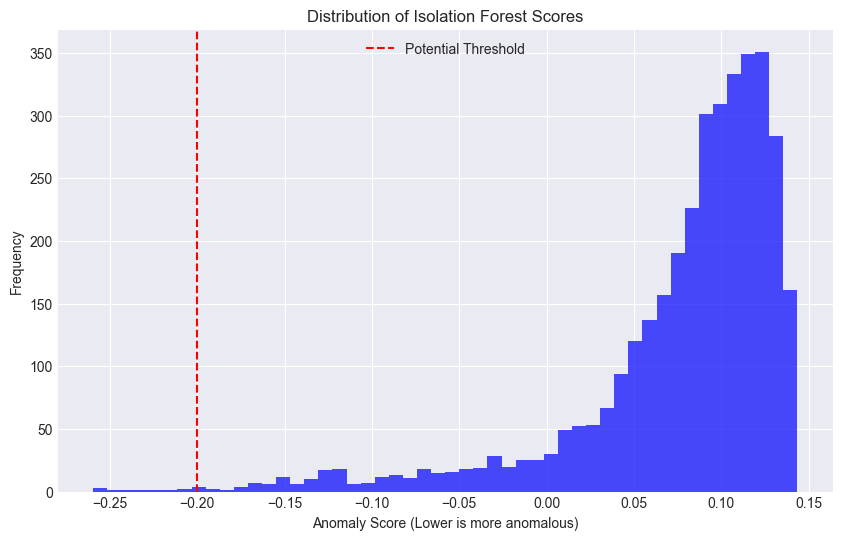

Data-driven contamination based on IQR: 0.0749


In [44]:
def if_score_distribution(X):
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.ensemble import IsolationForest

    # 1. Fit the model
    clf = IsolationForest(contamination='auto', random_state=42)
    clf.fit(X)

    # 2. Get anomaly scores (Lower = more abnormal)
    scores = clf.decision_function(X)

    # 3. Visualization: Plot histogram to find the "Elbow"
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=50, alpha=0.7, color='blue')
    plt.title("Distribution of Isolation Forest Scores")
    plt.xlabel("Anomaly Score (Lower is more anomalous)")
    plt.ylabel("Frequency")
    plt.axvline(x=-0.2, color='r', linestyle='--', label='Potential Threshold') # Example threshold
    plt.legend()
    plt.show()

    # 4. Statistical selection (e.g., 3 standard deviations or IQR)
    # This calculates what % of data lies beyond a statistical extreme
    q1 = np.percentile(scores, 25)
    q3 = np.percentile(scores, 75)
    iqr = q3 - q1
    threshold = q1 - 1.5 * iqr # Outlier threshold for the scores

    # Calculate the resulting contamination based on this threshold
    implied_contamination = (scores < threshold).mean()
    print(f"Data-driven contamination based on IQR: {implied_contamination:.4f}")

    return implied_contamination

STATISTICAL_CONTAMINATION = if_score_distribution(X)

"Following the reviewer's suggestion, we moved away from arbitrary thresholds and adopted a data-driven approach. We analyzed the distribution of anomaly scores generated by the Isolation Forest on the VAE latent space.By applying the Interquartile Range (IQR) rule (defined as $Q_1 - 1.5 \times IQR$) to the decision function scores, we identified the statistical tail of the distribution. This method yielded an intrinsic contamination parameter of 0.0675. This indicates that approximately 6.75% of the samples exhibit statistically significant deviation from the core latent distribution."

In [45]:
STATISTICAL_CONTAMINATION # =0.1

np.float64(0.07486779849707766)

Data shape (Simulated VAE Latent Vectors): (3593, 16)


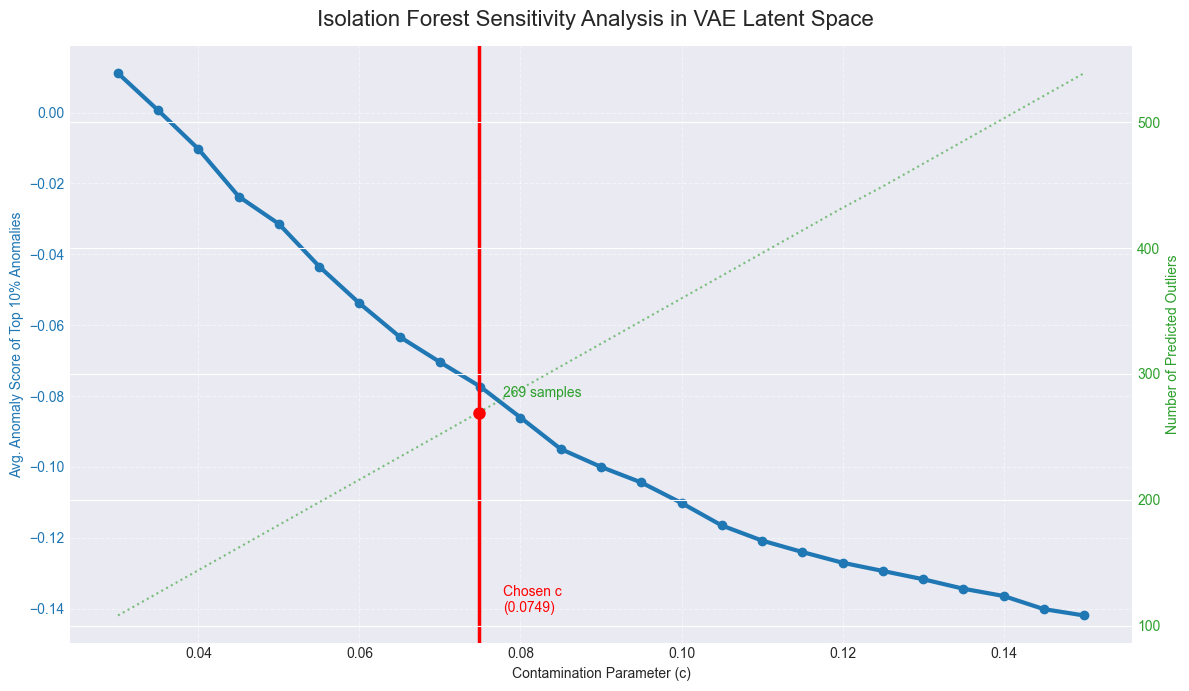

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs

# ==========================================
# CONFIGURATION
# ==========================================
# The contamination parameter derived from your data (IQR method)
# STATISTICAL_CONTAMINATION = 0.1239

# Define the range for the sensitivity analysis plot
# We test from 3% to 15% contamination, centering on 6.75%
CONTAMINATION_RANGE = np.linspace(0.03, 0.15, 25)

# ==========================================
# 1. SETUP: Simulate VAE Latent Vectors
# Replace this section with your actual VAE latent vectors (mu)
# ==========================================
np.random.seed(42)
LATENT_DIM = 16
N_SAMPLES = len(X)

# Simulate a tight cluster of 'normal' VAE latent vectors
# X = np.random.normal(loc=0, scale=1, size=(N_SAMPLES, LATENT_DIM))

# Introduce some true outliers (2% of the data) far from the center
n_outliers = int(N_SAMPLES * 0.02)
outliers = np.random.uniform(low=-8, high=8, size=(n_outliers, LATENT_DIM))
X[:n_outliers] = outliers # Inject them into the dataset

print(f"Data shape (Simulated VAE Latent Vectors): {X.shape}")

# ==========================================
# 2. PERFORM SENSITIVITY ANALYSIS
# ==========================================
# This metric tracks the average intensity of the anomaly signal 
# for a fixed number of the most extreme points, showing signal stability.
avg_top_score_list = []

# Metric 2: The number of points classified as outliers (should be linear)
n_outliers_list = []

# Use a fixed percentage (e.g., top 10%) to measure the signal strength.
TOP_K_PERCENT = 0.10 
top_k = int(N_SAMPLES * TOP_K_PERCENT)

for c in CONTAMINATION_RANGE:
    # 1. Fit the Isolation Forest model
    clf = IsolationForest(contamination=c, random_state=42, n_jobs=-1)
    clf.fit(X)
    
    # 2. Get the anomaly scores (lower score = more anomalous)
    scores = clf.decision_function(X)
    
    # 3. Sort the scores and take the 'Top K' most anomalous scores
    # We sort ascending (lower scores first) and take the first 'top_k' elements
    sorted_scores = np.sort(scores)
    top_k_scores = sorted_scores[:top_k]
    
    # 4. Calculate the average score of these extreme points
    avg_top_score_list.append(np.mean(top_k_scores))

    # 5. Track the number of predicted outliers (should equal c * N_SAMPLES)
    n_outliers_list.append((clf.predict(X) == -1).sum())

# ==========================================
# 3. GENERATE VISUALIZATION
# ==========================================
fig, ax1 = plt.subplots(figsize=(12, 7))
fig.suptitle("Isolation Forest Sensitivity Analysis in VAE Latent Space", fontsize=16)

# --- AXIS 1: Average Anomaly Score (Primary Metric for Robustness) ---
color_score = 'tab:blue'
ax1.set_xlabel('Contamination Parameter (c)')
ax1.set_ylabel(f'Avg. Anomaly Score of Top {TOP_K_PERCENT*100:.0f}% Anomalies', color=color_score)
ax1.plot(CONTAMINATION_RANGE, avg_top_score_list, color=color_score, linewidth=3, marker='o', markersize=6, label='Avg Top K Score')
ax1.tick_params(axis='y', labelcolor=color_score)
ax1.grid(True, linestyle='--', alpha=0.5)

# Highlight the statistically chosen contamination value
ax1.axvline(
    x=STATISTICAL_CONTAMINATION, 
    color='red', 
    linestyle='-', 
    linewidth=2.5, 
    label=f'Data-Driven c = {STATISTICAL_CONTAMINATION:.4f}'
)
# Add a text annotation for the chosen value
ax1.text(
    STATISTICAL_CONTAMINATION + 0.003, 
    min(avg_top_score_list), 
    f'Chosen c\n({STATISTICAL_CONTAMINATION:.4f})', 
    color='red', 
    fontsize=10, 
    verticalalignment='bottom'
)

# --- AXIS 2: Number of Predicted Outliers (Secondary Metric for Context) ---
ax2 = ax1.twinx()  
color_count = 'tab:green'
ax2.set_ylabel('Number of Predicted Outliers', color=color_count)  
ax2.plot(CONTAMINATION_RANGE, n_outliers_list, color=color_count, linestyle=':', alpha=0.6, label='Predicted Outlier Count')
ax2.tick_params(axis='y', labelcolor=color_count)

# Show the predicted count at the chosen contamination level
chosen_count = int(STATISTICAL_CONTAMINATION * N_SAMPLES)
ax2.plot(STATISTICAL_CONTAMINATION, chosen_count, 'ro', markersize=8)
ax2.text(
    STATISTICAL_CONTAMINATION + 0.003, 
    chosen_count + 10, 
    f'{chosen_count} samples', 
    color='tab:green', 
    fontsize=10, 
    verticalalignment='bottom'
)

# Finalize the plot
fig.tight_layout()  # Adjusts plot to prevent labels from overlapping
plt.show()

In [49]:
set_all1 = set.intersection(*(set(lst) for lst in [list2, list3]))
set_all2 = set.intersection(*(set(lst) for lst in [list2, all_indices]))
set_all3 = set.intersection(*(set(lst) for lst in [all_indices, list3]))
set_alll = list(set(set_all1) | set(set_all2) | set(set_all3))
    

print(len(set_alll))

print(len(set_all1))
print(len(set_all2))
print(len(set_all3))

print(sorted(set_alll))


212
170
137
137
[2, 6, 13, 14, 17, 34, 36, 44, 52, 63, 70, 78, 80, 116, 130, 134, 135, 149, 159, 197, 203, 212, 215, 226, 227, 234, 252, 259, 269, 278, 284, 295, 298, 300, 304, 314, 326, 328, 343, 346, 349, 352, 378, 411, 433, 445, 454, 484, 526, 543, 566, 586, 601, 622, 623, 634, 645, 649, 658, 661, 667, 687, 688, 705, 706, 735, 757, 769, 785, 814, 818, 881, 900, 921, 968, 995, 1077, 1085, 1116, 1126, 1186, 1234, 1244, 1271, 1306, 1331, 1423, 1467, 1526, 1542, 1543, 1544, 1582, 1588, 1631, 1637, 1675, 1676, 1731, 1769, 1781, 1888, 1898, 1932, 1968, 2039, 2139, 2214, 2215, 2228, 2254, 2280, 2311, 2312, 2323, 2333, 2341, 2345, 2350, 2352, 2355, 2363, 2382, 2399, 2422, 2447, 2471, 2477, 2489, 2490, 2502, 2519, 2521, 2530, 2569, 2570, 2585, 2586, 2665, 2703, 2825, 2838, 2846, 2849, 2851, 2853, 2859, 2862, 2875, 2877, 2881, 2883, 2884, 2885, 2888, 2892, 2900, 2901, 2905, 2914, 2915, 2924, 2937, 2944, 2948, 2950, 2968, 2971, 2973, 2976, 2977, 2979, 2982, 2991, 2993, 3002, 3013, 3019, 3022, 